### 1. Data and Library load

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
base_path = "/Volumes/GoogleDrive/My Drive/fastcamp/datas/energy/"
train = pd.read_csv(base_path + "train.csv", encoding='cp949')
test = pd.read_csv(base_path + "test.csv", encoding='cp949')
submission = pd.read_csv(base_path + "sample_submission.csv", encoding='cp949')

### 2. Data Preprocessing with EDA

- 학습 기간 : 2020-06-01 00 ~ 2020-08-24 23

- 예측 기간 : 2020-08-25 00 ~ 2020-08-31 23

- 예측 기간 데이터는 기상청 예보 데이터를 활용 데이터를 사용하기 때문에 기록 시간 단위가 3시간 6시간이다.

### Data Preprocessing

1. 결측치 처리

2. feature selection (분석에 사용하지 않을 column 제거)

3. target distribution

4. time series to find out implied pattern

5. test data 결측치 처리

In [32]:
# column 이름 영어로 바꾸자
train.columns

train.columns = ["num", "date_time", "target", "temperature", "windspeed", "humidity", 
                 "precipitation", "insolation", "elec_cool", "solar"]

test.columns = ["num", "date_time", "temperature", "windspeed", "humidity", 
                 "precipitation", "insolation", "elec_cool", "solar"]

In [33]:
train.info() # 완벽
test.info() # null 많다.

# null의 이유 : 기록 시간의 단위 
# 기온(°C)        3360 non-null   
# 풍속(m/s)       3360 non-null
# 일조(hr, 3시간)   3360 non-null 
# 강수량(mm, 6시간)  1680 non-nul

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num            122400 non-null  int64  
 1   date_time      122400 non-null  object 
 2   target         122400 non-null  float64
 3   temperature    122400 non-null  float64
 4   windspeed      122400 non-null  float64
 5   humidity       122400 non-null  float64
 6   precipitation  122400 non-null  float64
 7   insolation     122400 non-null  float64
 8   elec_cool      122400 non-null  float64
 9   solar          122400 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 9.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   num            10080 non-null  int64  
 1   date_time      10080 non-null  object 
 2 

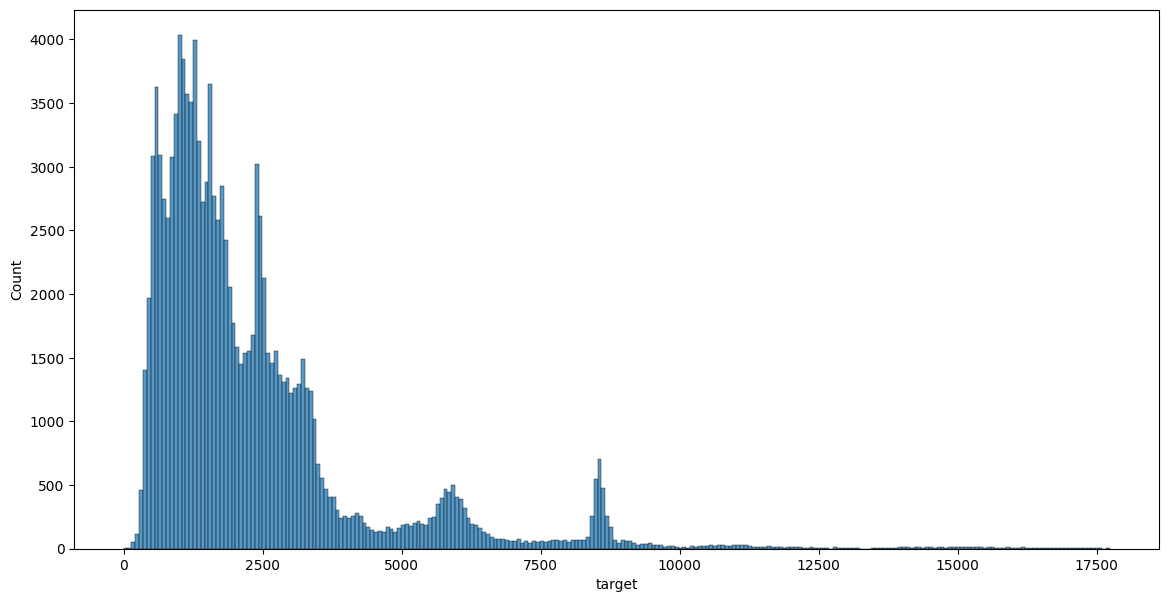

In [34]:
plt.figure(figsize = (14, 7))
sns.histplot(data = train, x = "target")
plt.show()

<AxesSubplot: ylabel='target'>

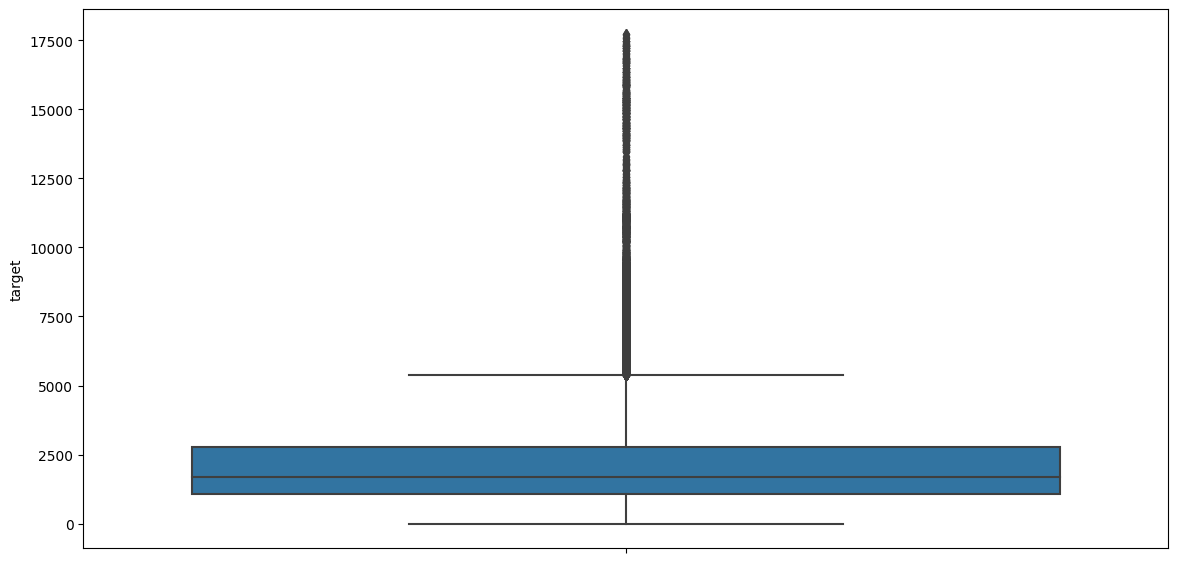

In [35]:
# boxplot : 정규분포가 아닌 경우 -> 데이터가 치우쳐 있다. 따라서 박스플롯 쓰면 이상치가 많이 나올 수 밖에 없어서 생각을 해봐야한다. 
plt.figure(figsize = (14, 7))
sns.boxplot(data = train, y = "target")

In [37]:
train[train["target"] > 17000].shape

(40, 10)

<AxesSubplot: xlabel='num', ylabel='target'>

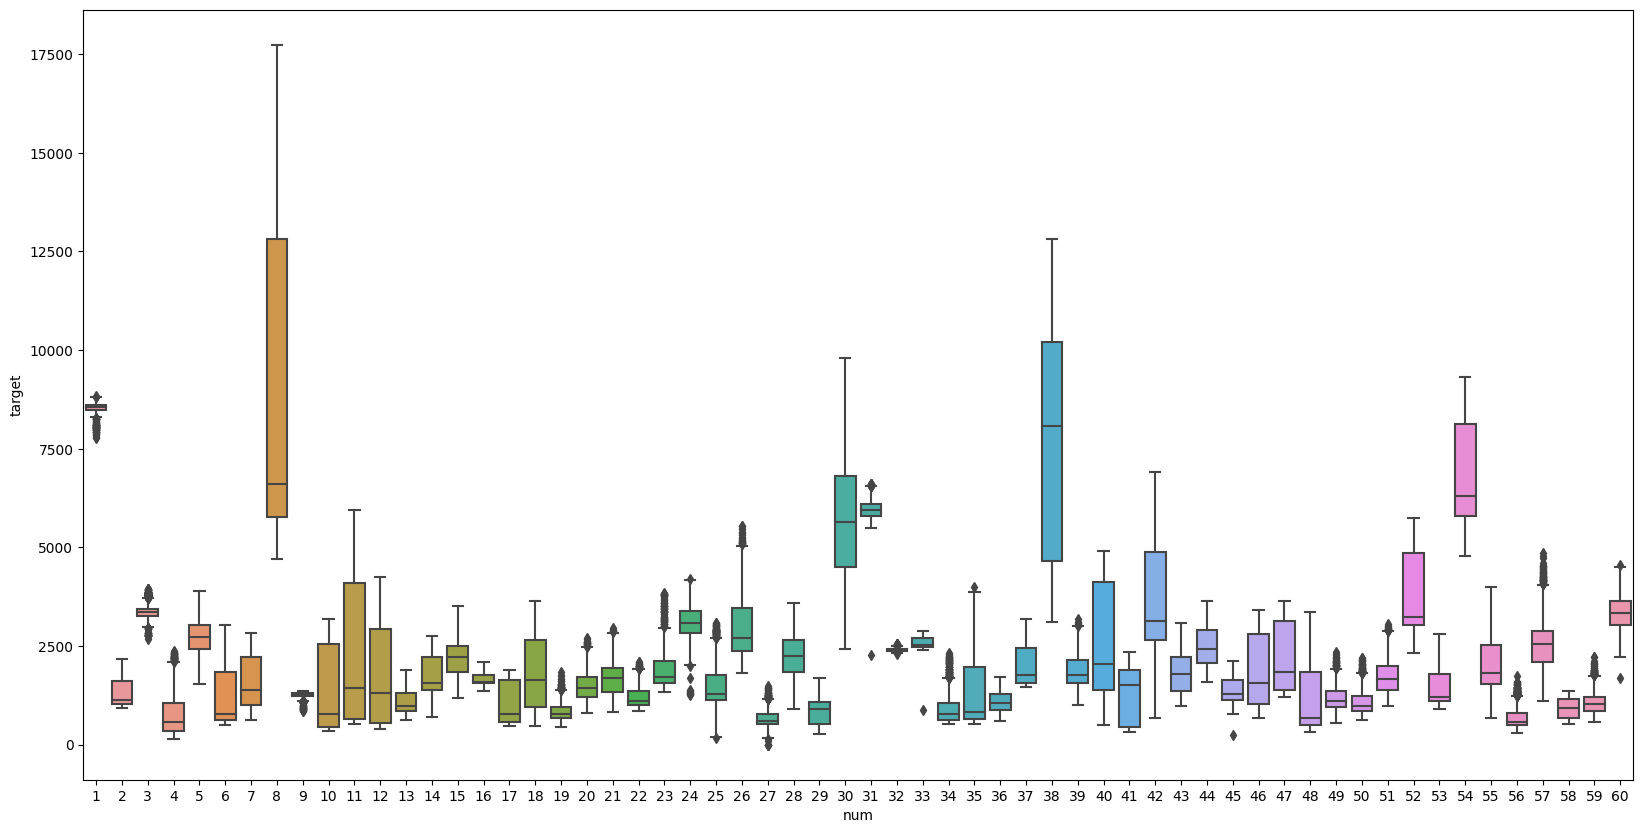

In [38]:
# 건물별 전력사용량을 확인해보자
# 찍어보면 알 수 있는 점 : 건물별 전력 사용량 패턴이 다르다. 
# 이전에 이상치들이 결국 8번 건물이였다는 것을 알 수 있다. 
# 또한 8번 건물의 박스폴롯에는 이상치가 없음을 알 수 있다.
plt.figure(figsize = (20, 10))
sns.boxplot(data = train, x = "num", y = "target")

In [39]:
# date_time 타입 datetime으로 변경하자
train.date_time = pd.to_datetime(train.date_time)
test.date_time = pd.to_datetime(test.date_time)

In [40]:
train

num           date_time    target  temperature  windspeed  humidity  \
0         1 2020-06-01 00:00:00  8179.056         17.6        2.5      92.0   
1         1 2020-06-01 01:00:00  8135.640         17.7        2.9      91.0   
2         1 2020-06-01 02:00:00  8107.128         17.5        3.2      91.0   
3         1 2020-06-01 03:00:00  8048.808         17.1        3.2      91.0   
4         1 2020-06-01 04:00:00  8043.624         17.0        3.3      92.0   
...     ...                 ...       ...          ...        ...       ...   
122395   60 2020-08-24 19:00:00  4114.368         27.8        2.3      68.0   
122396   60 2020-08-24 20:00:00  3975.696         27.3        1.2      71.0   
122397   60 2020-08-24 21:00:00  3572.208         27.3        1.8      71.0   
122398   60 2020-08-24 22:00:00  3299.184         27.1        1.8      74.0   
122399   60 2020-08-24 23:00:00  3204.576         27.1        2.6      75.0   

        precipitation  insolation  elec_cool  solar  
0                 0.8         0.0        0.0    0.0  
1                 0.3         0.0        0.0    0.0  
2                 0.0         0.0        0.0    0.0  
3                 0.0         0.0        0.0    0.0  
4                 0.0         0.0        0.0    0.0  
...               ...         ...        ...    ...  
122395            0.0         0.7        1.0    1.0  
122396            0.0         0.0        1.0    1.0  
122397            0.0         0.0        1.0    1.0  
122398            0.0         0.0        1.0    1.0  
122399            0.0         0.0        1.0    1.0  

[122400 rows x 10 columns]

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


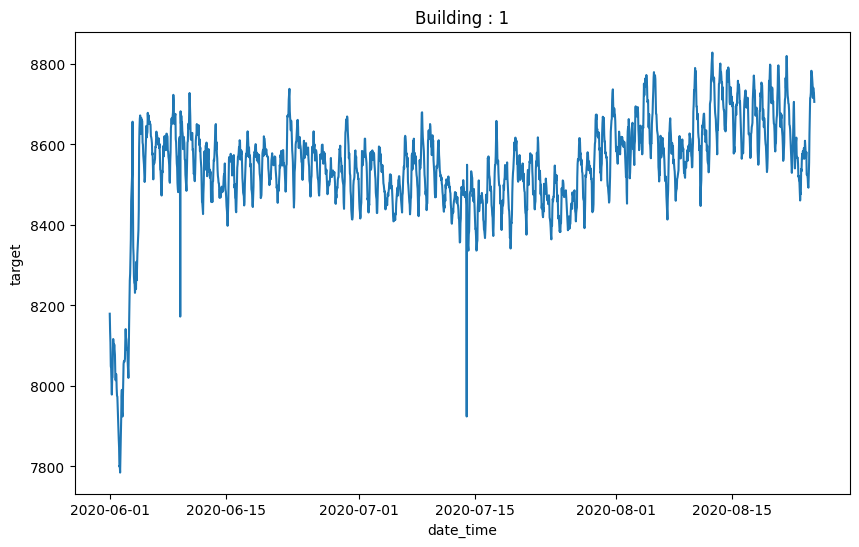

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


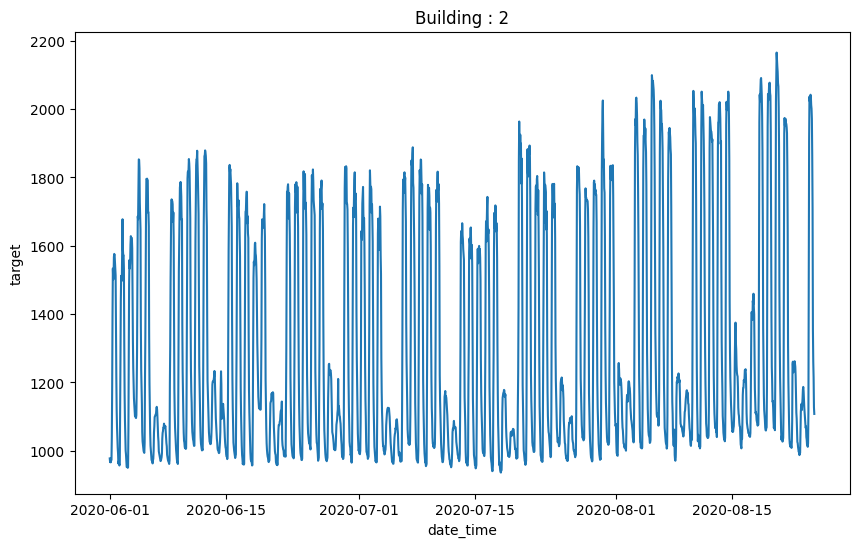

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


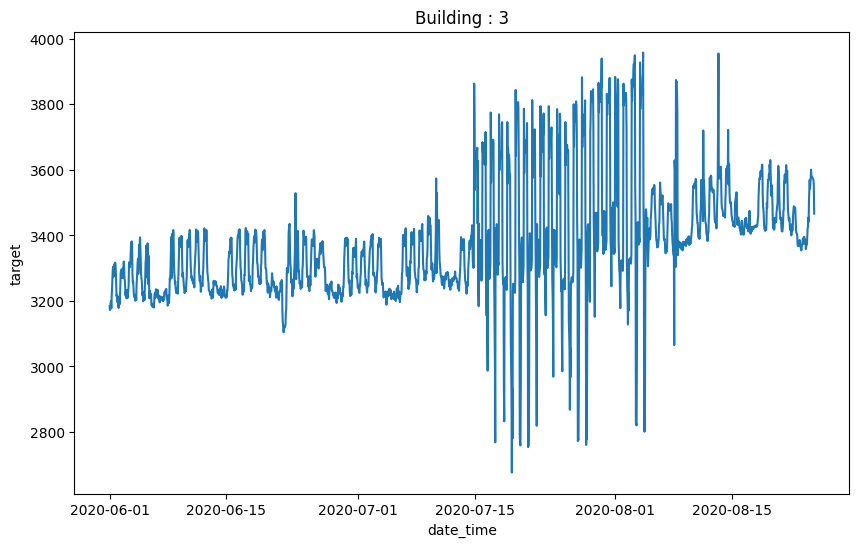

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


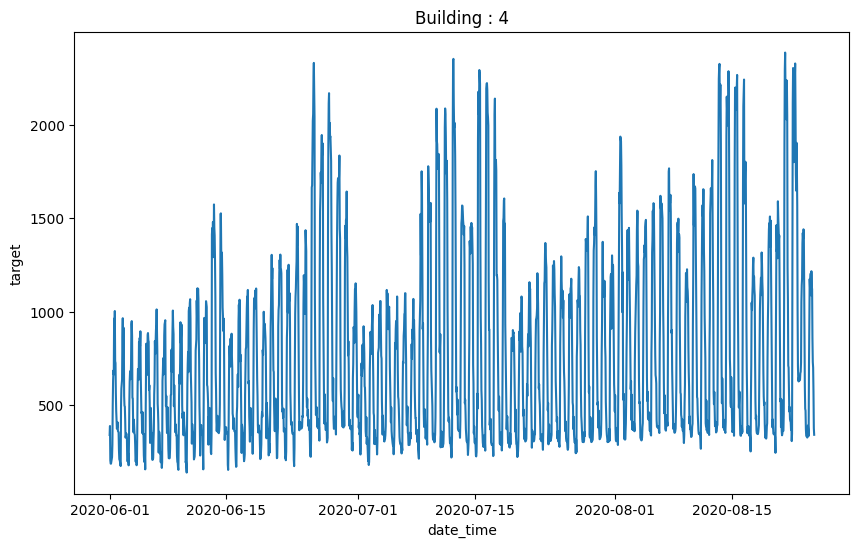

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


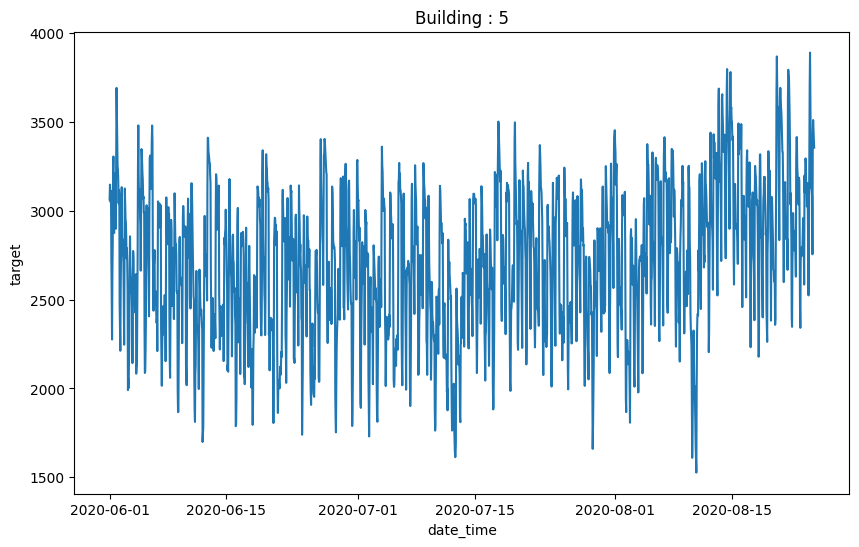

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


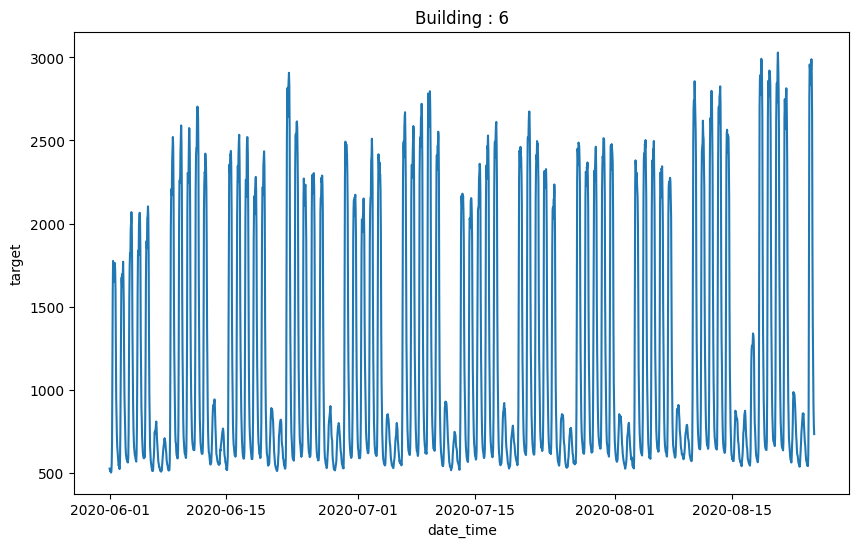

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


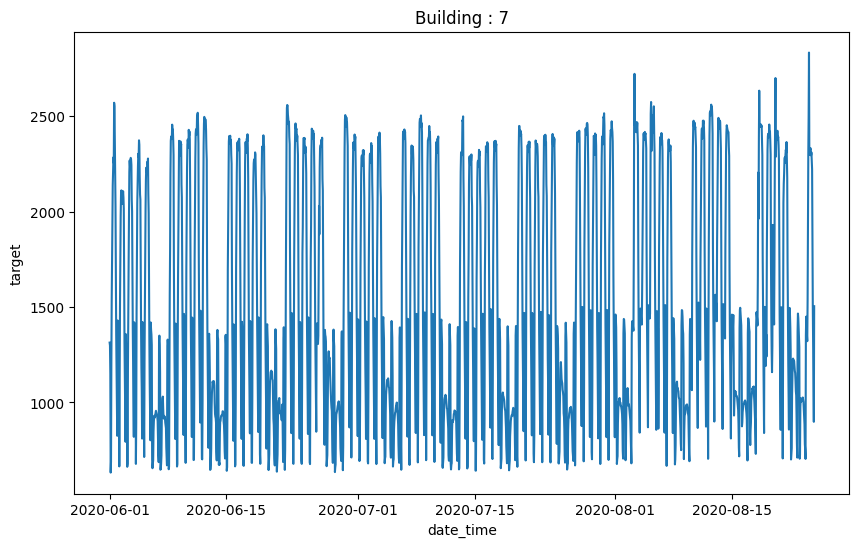

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


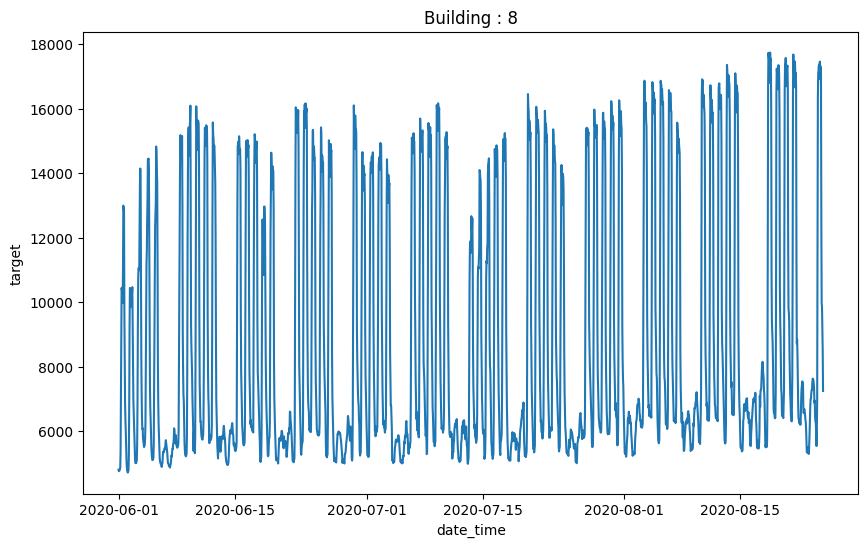

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


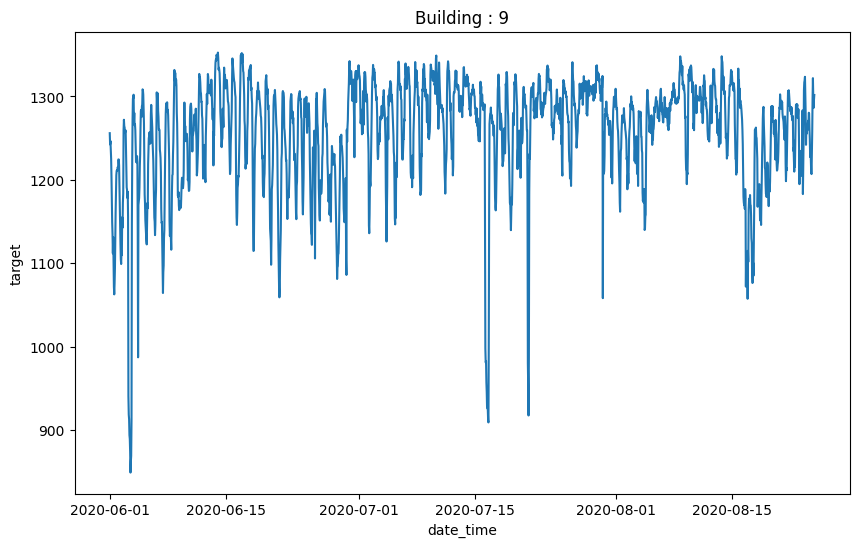

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


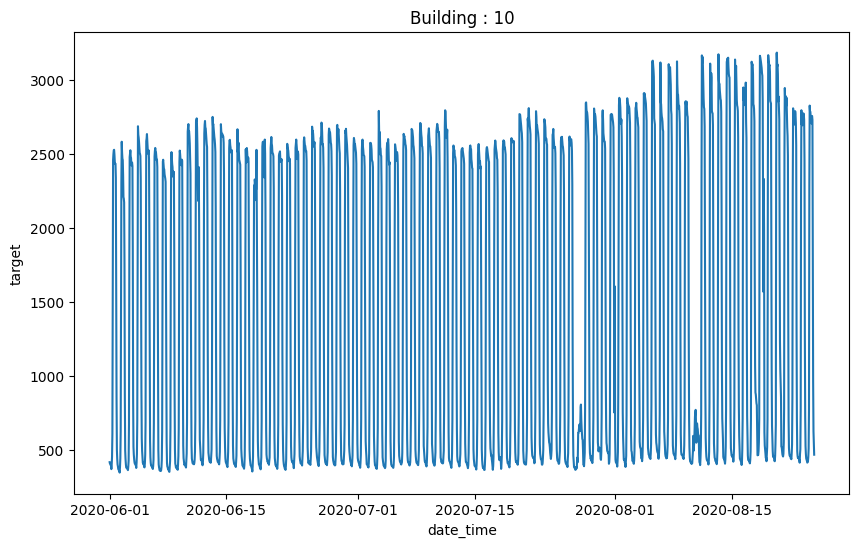

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


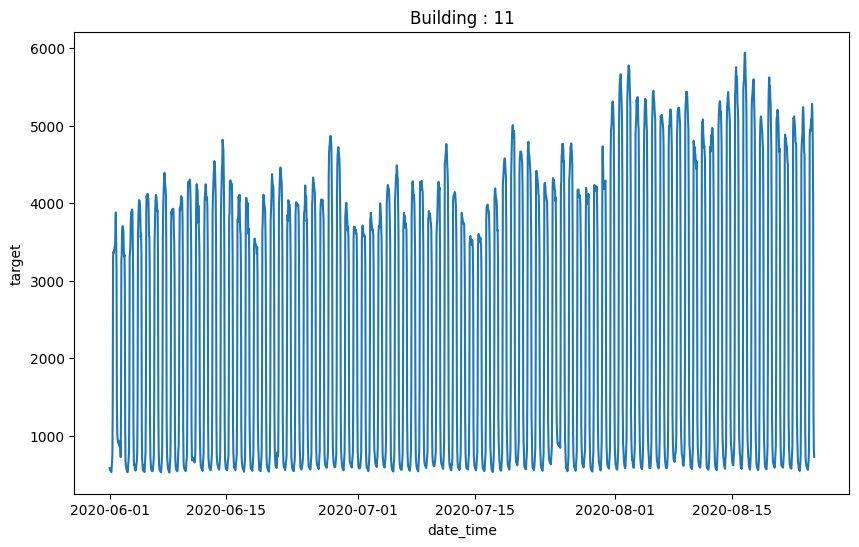

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


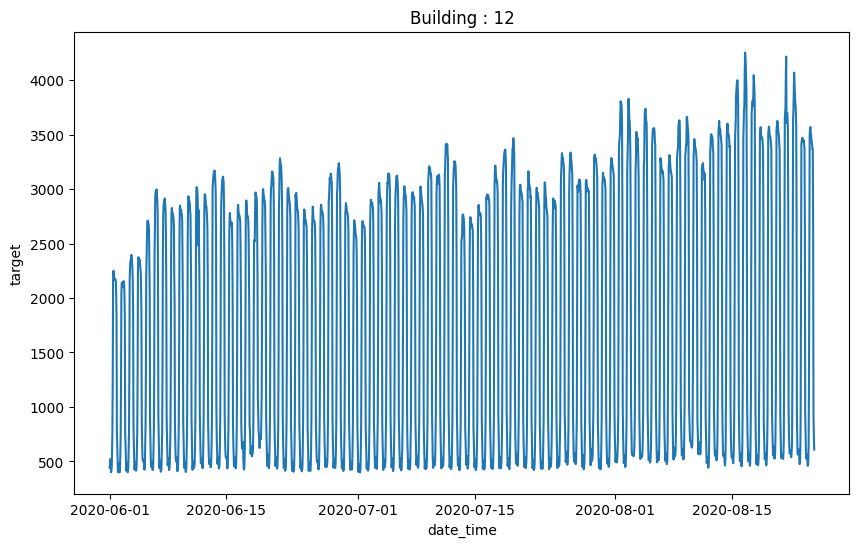

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


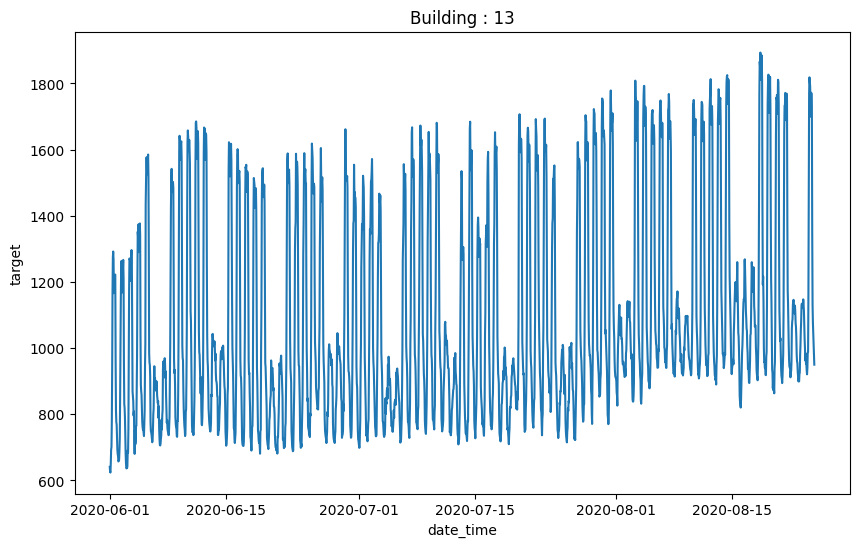

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


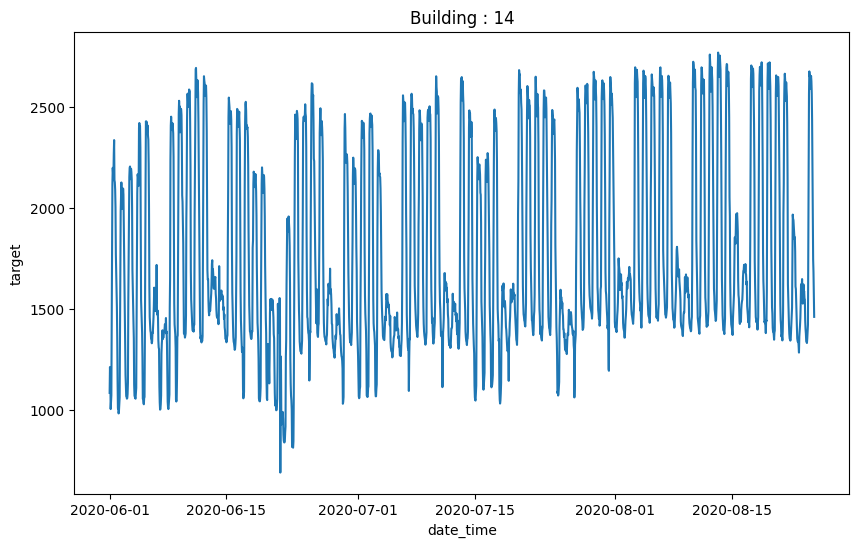

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


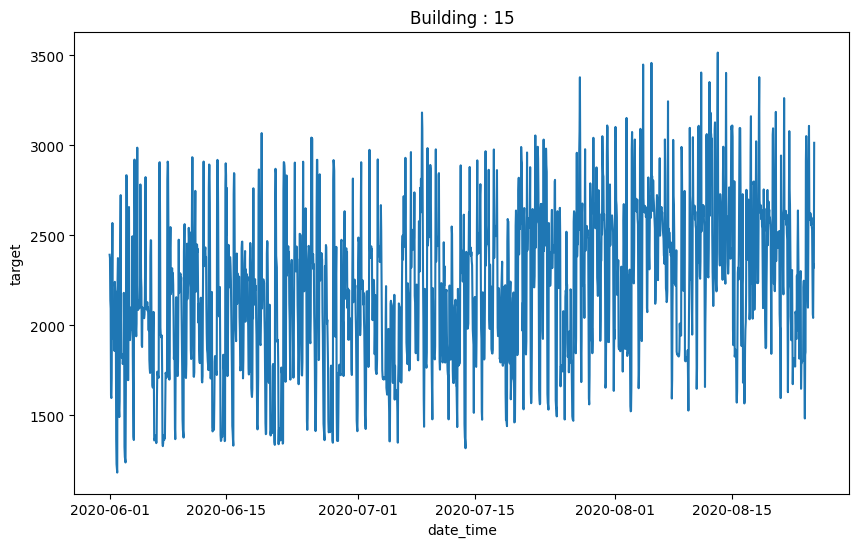

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


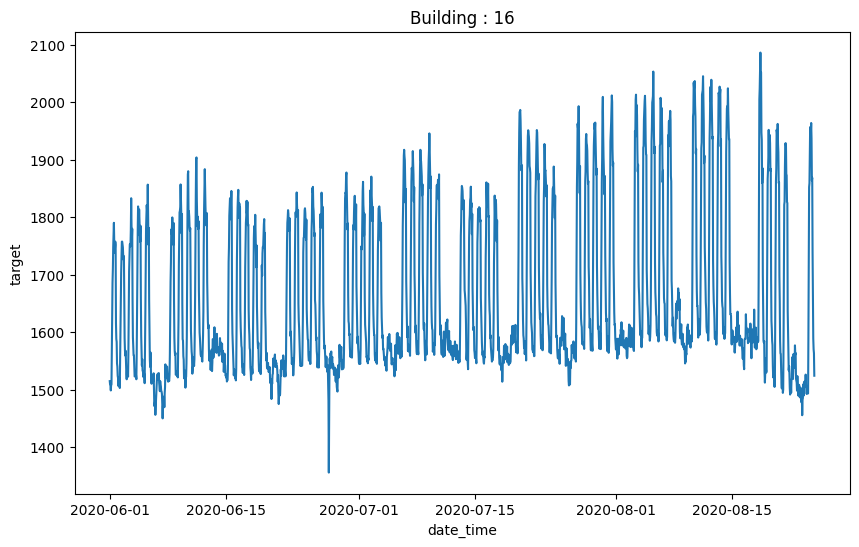

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


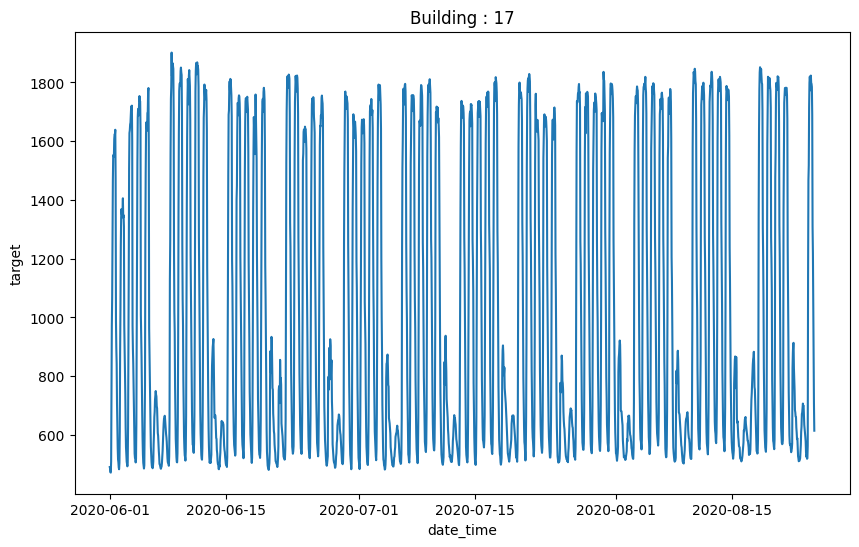

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


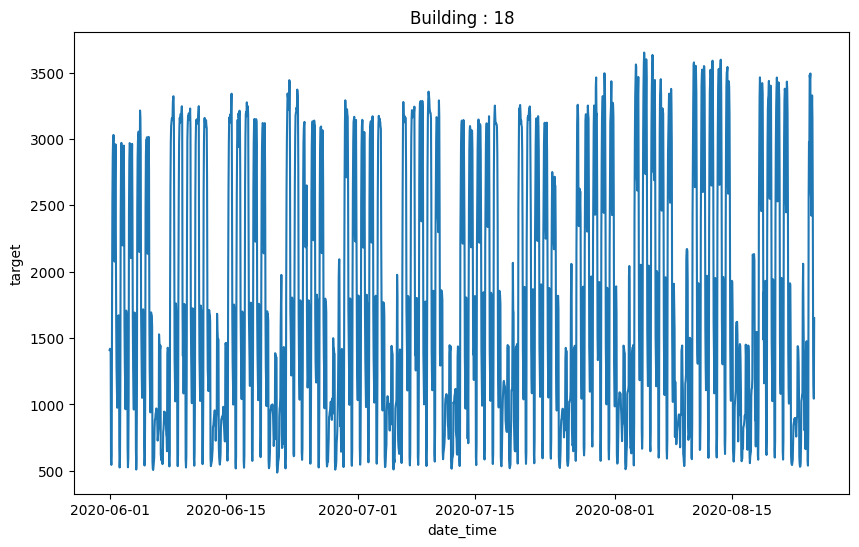

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


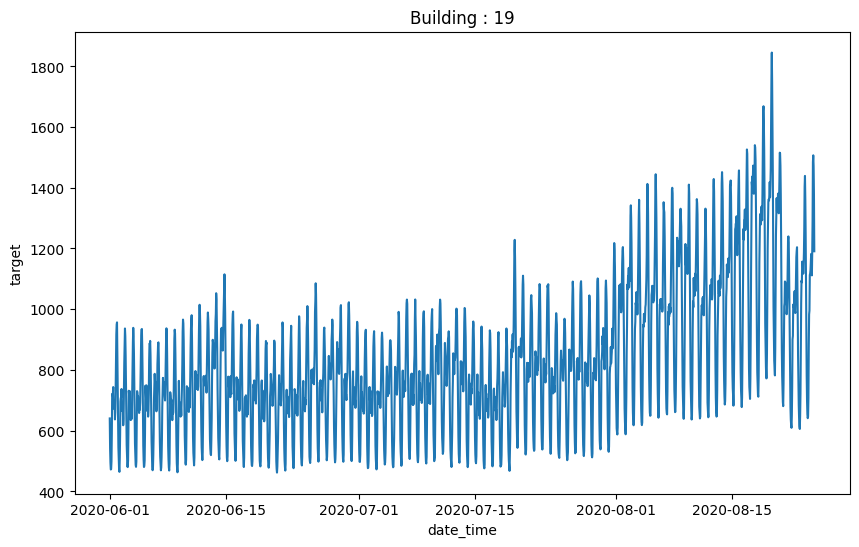

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


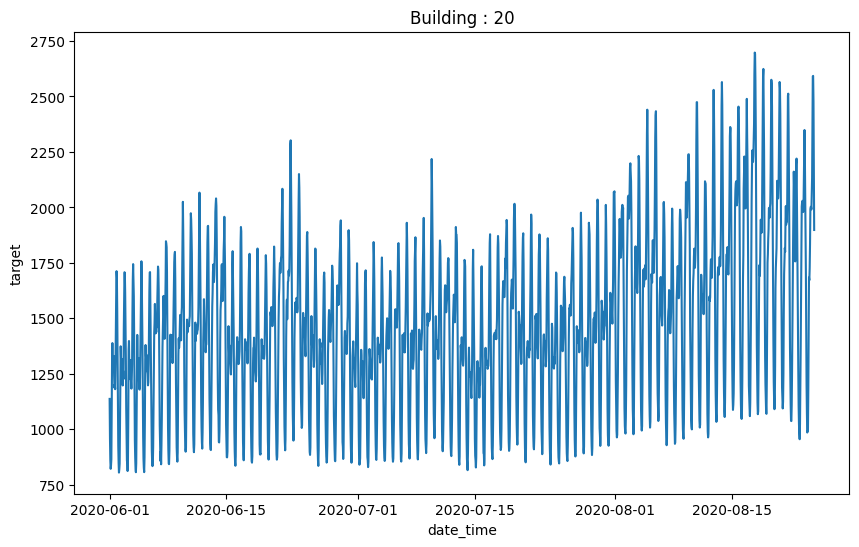

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


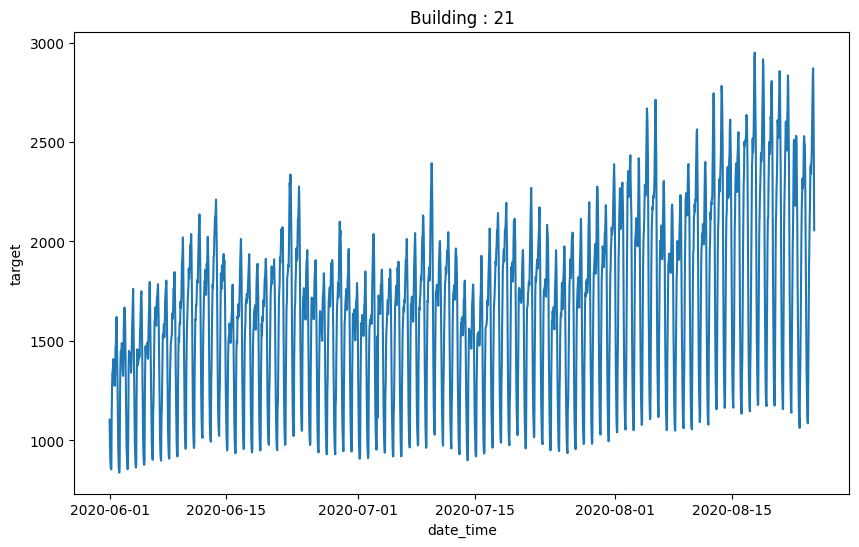

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


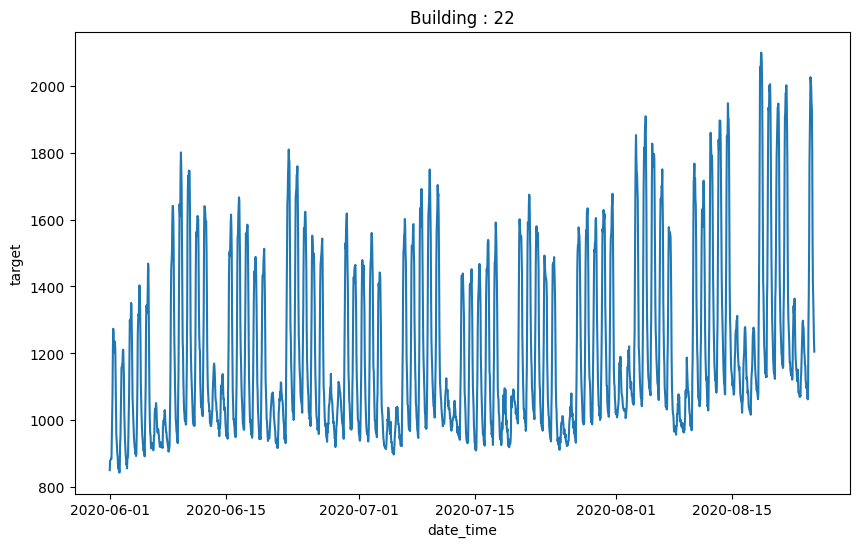

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


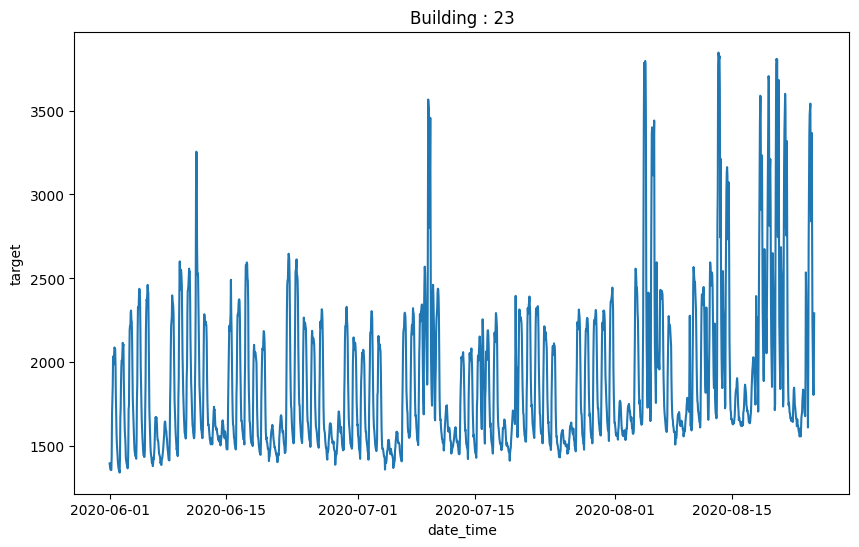

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


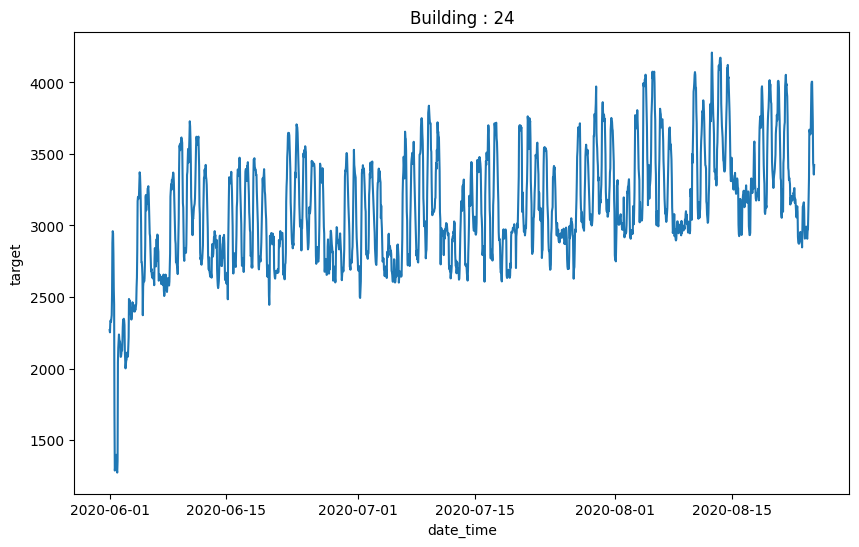

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


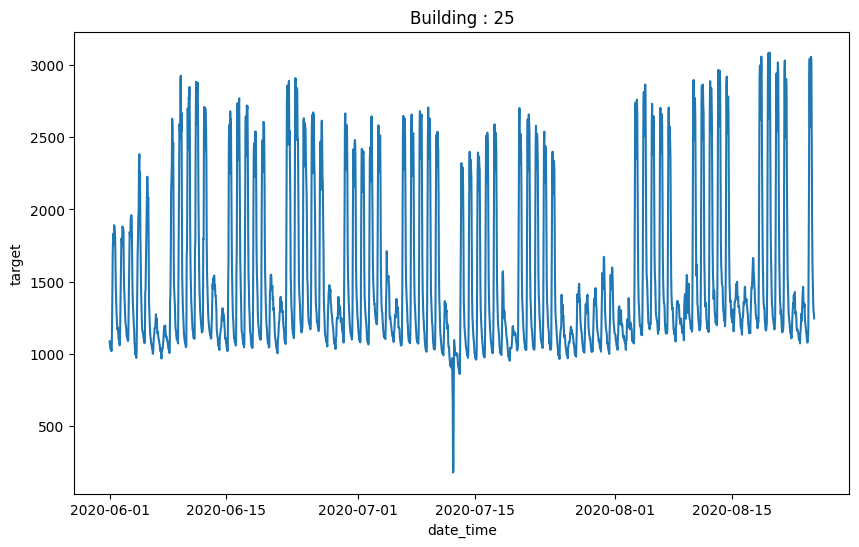

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


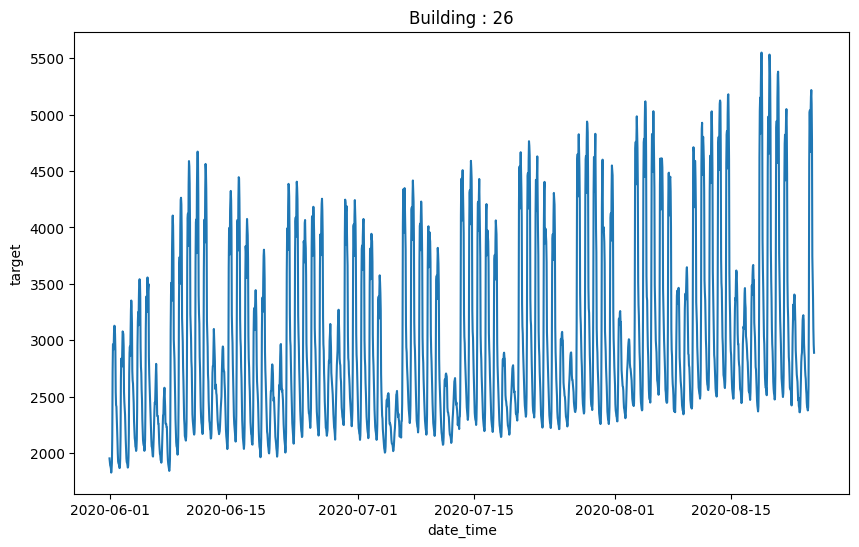

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


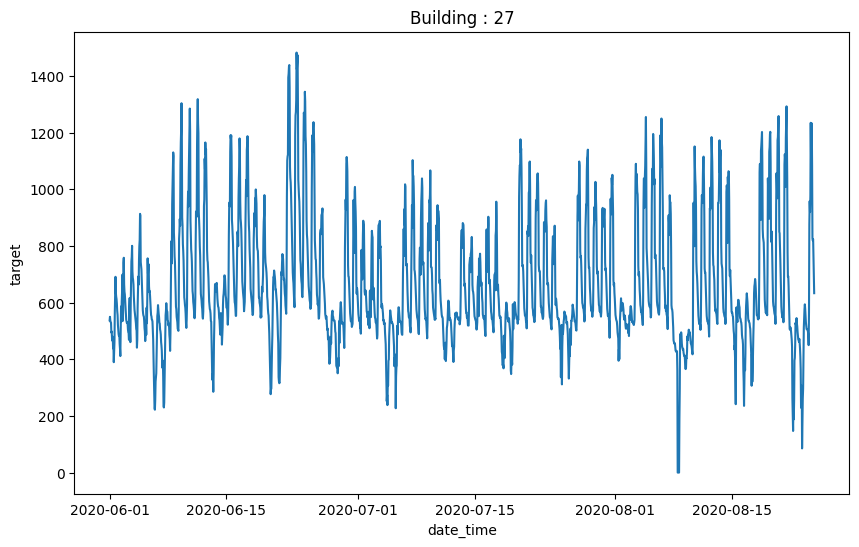

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


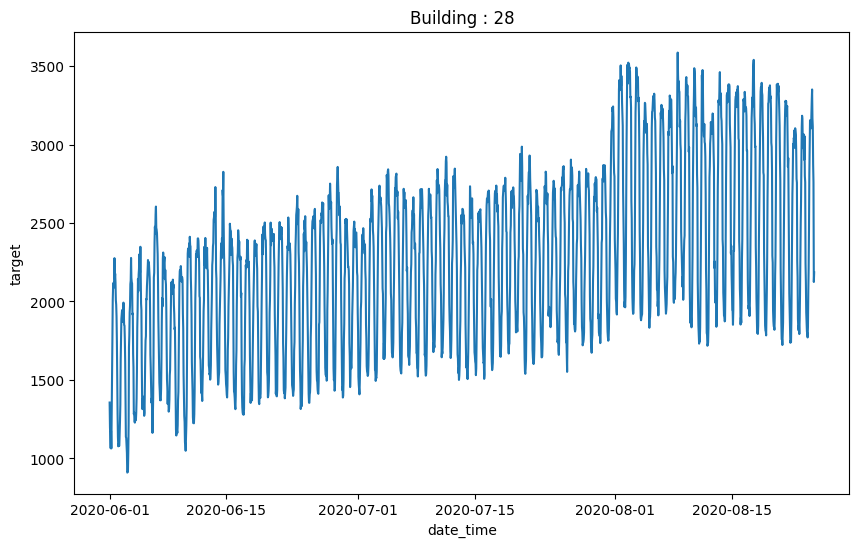

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


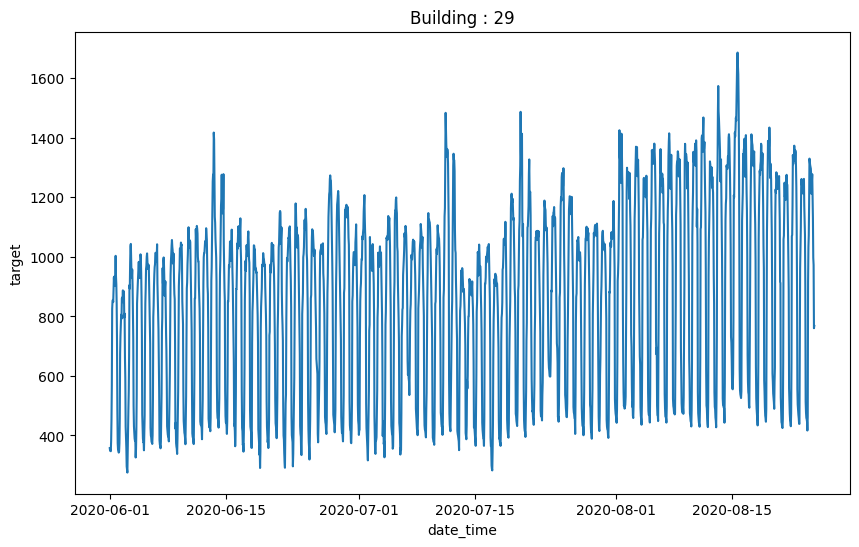

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


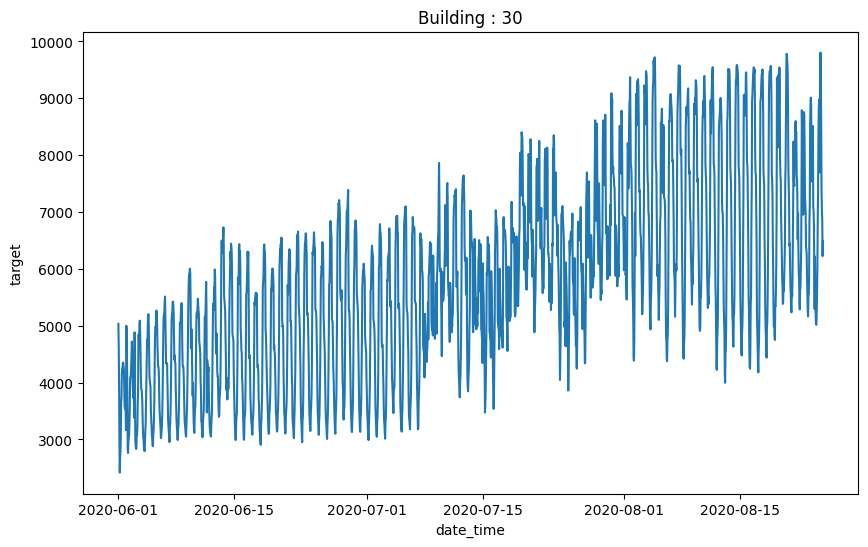

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


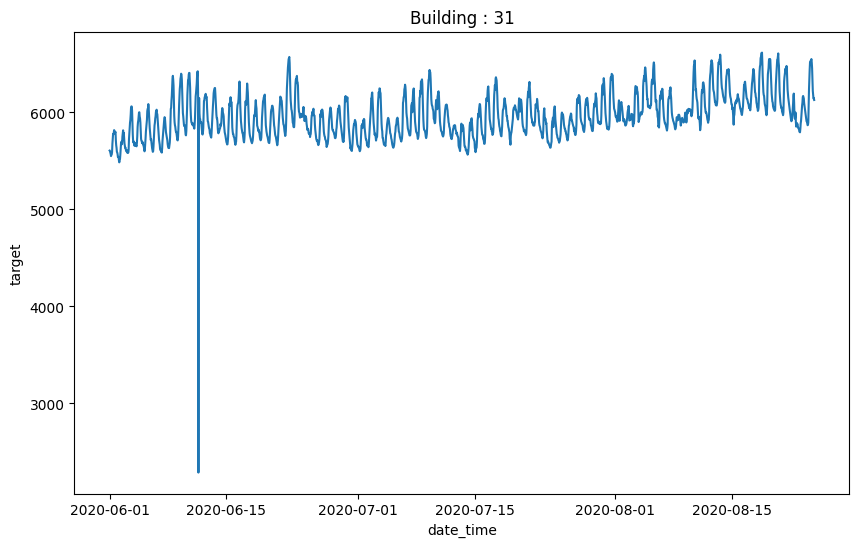

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


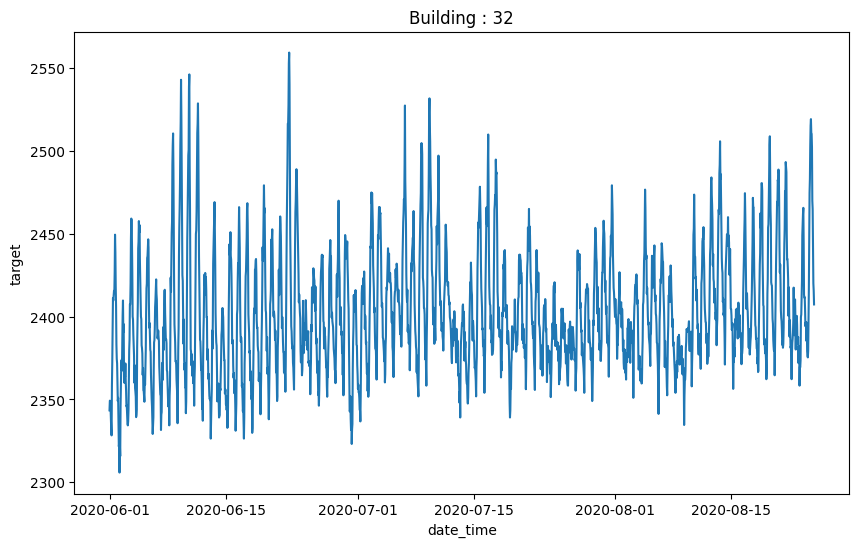

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


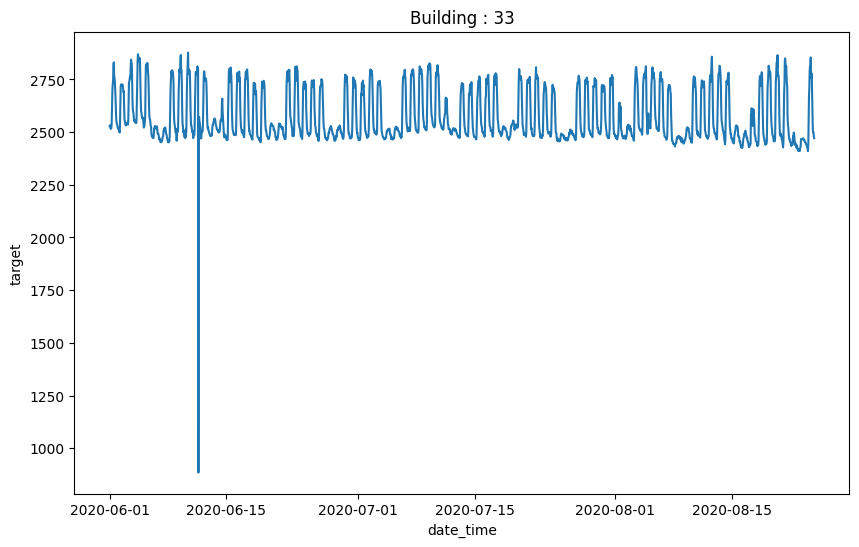

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


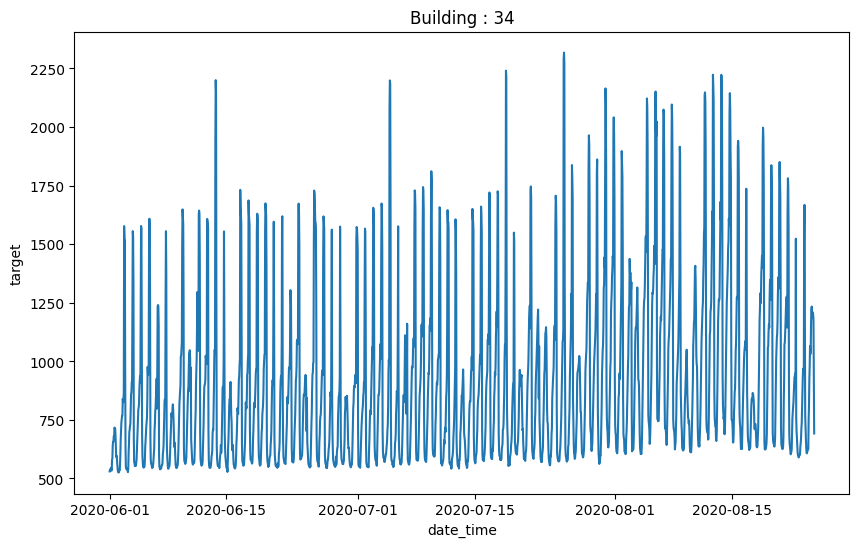

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


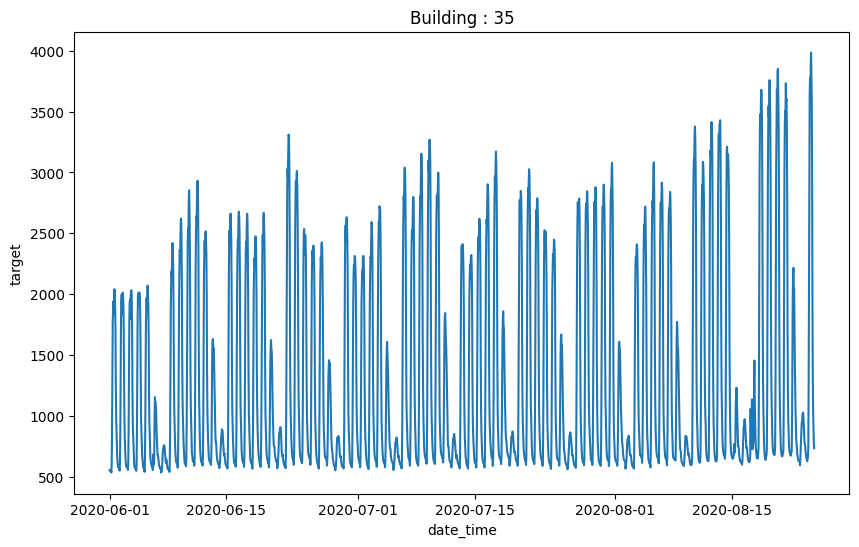

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


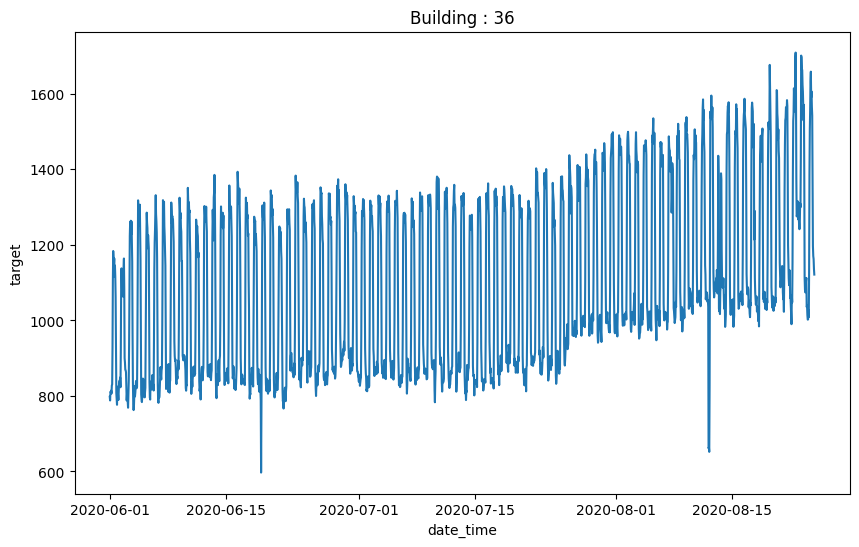

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


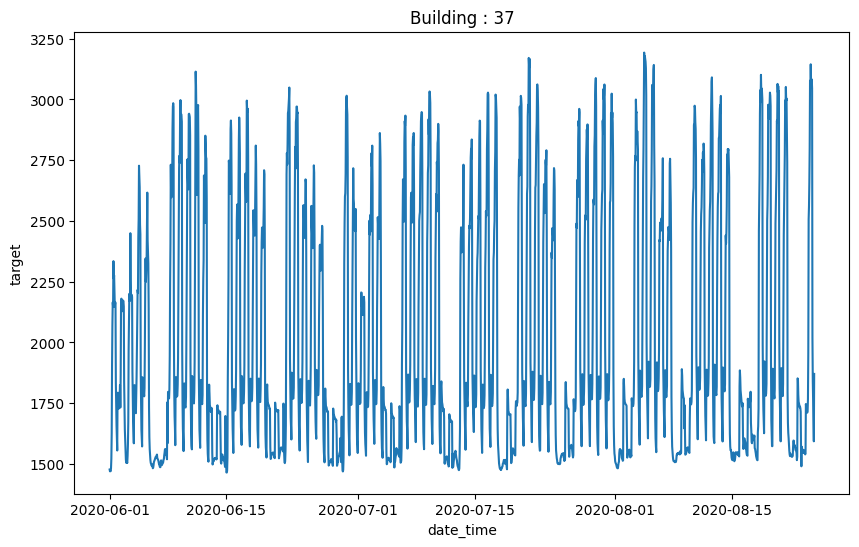

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


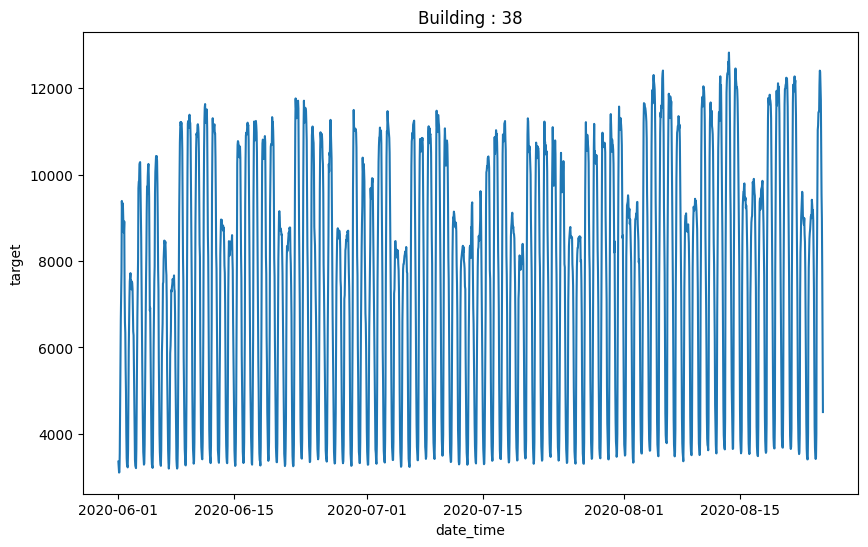

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


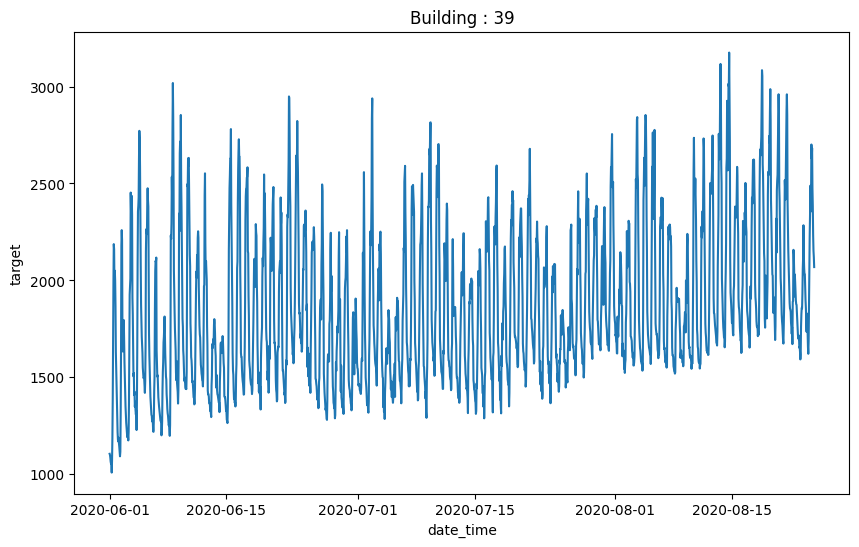

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


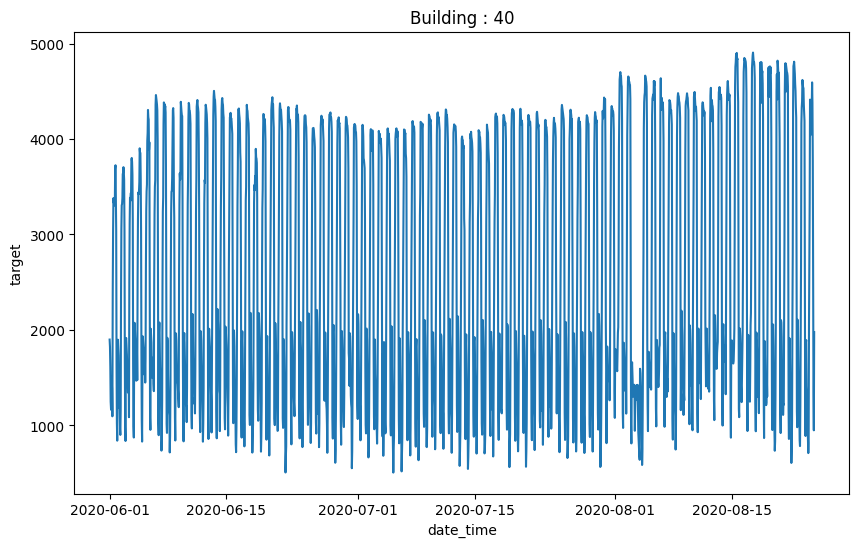

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


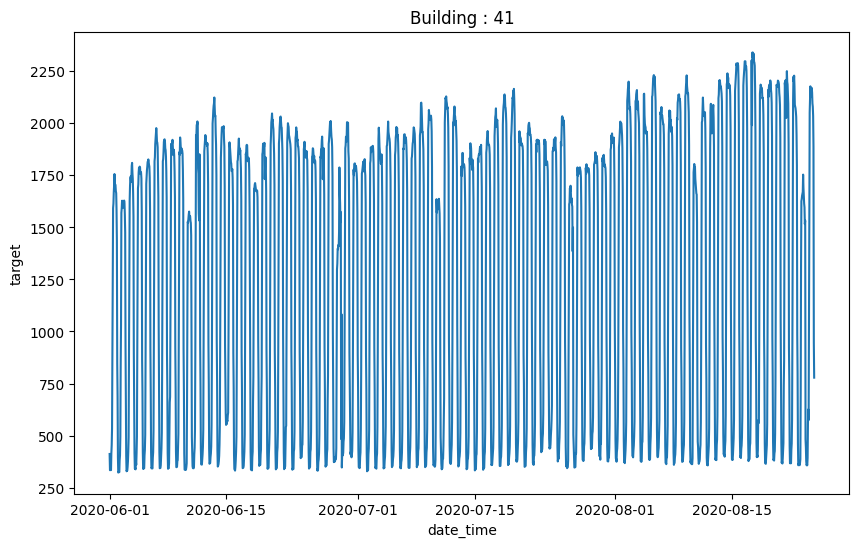

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


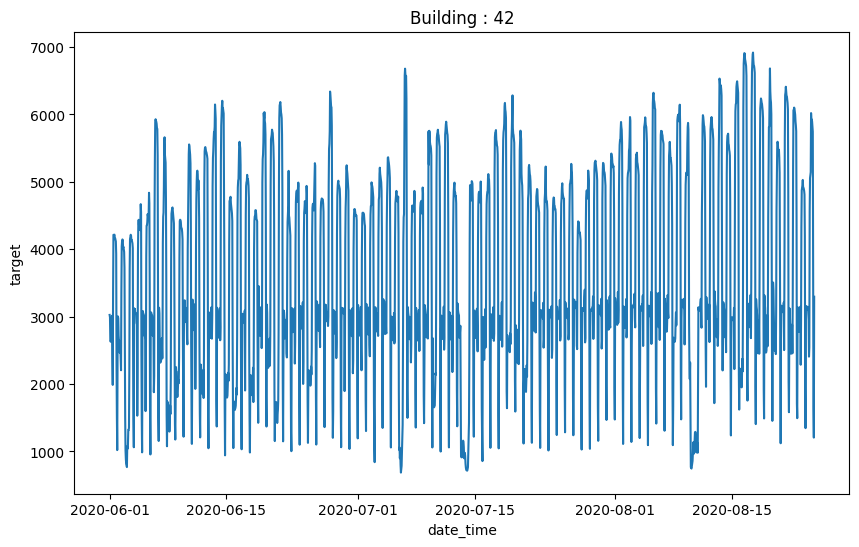

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


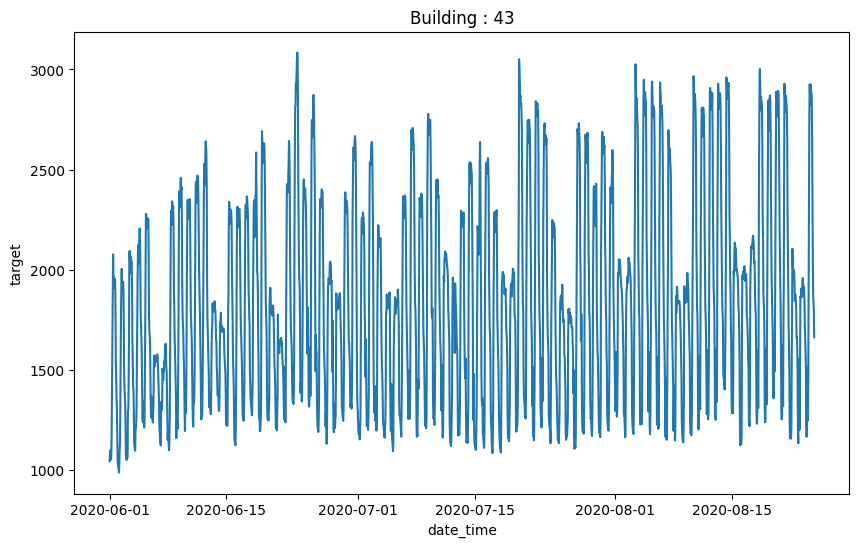

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


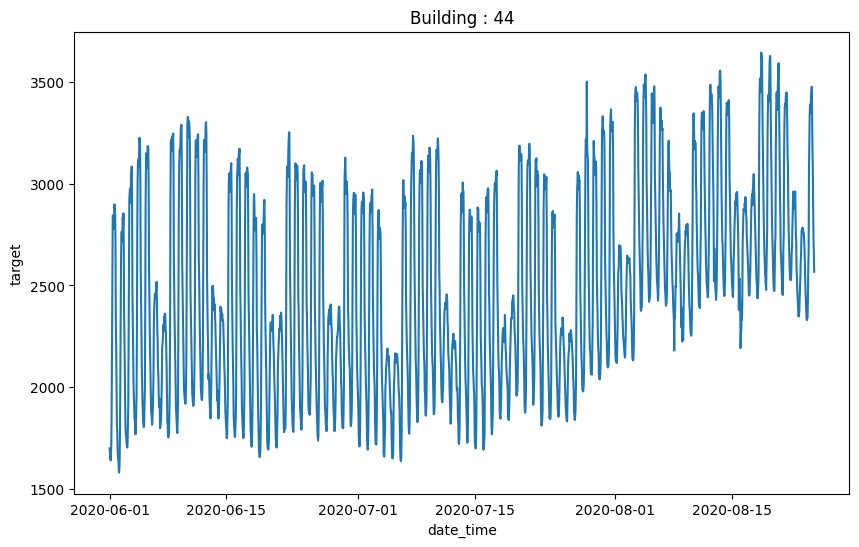

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


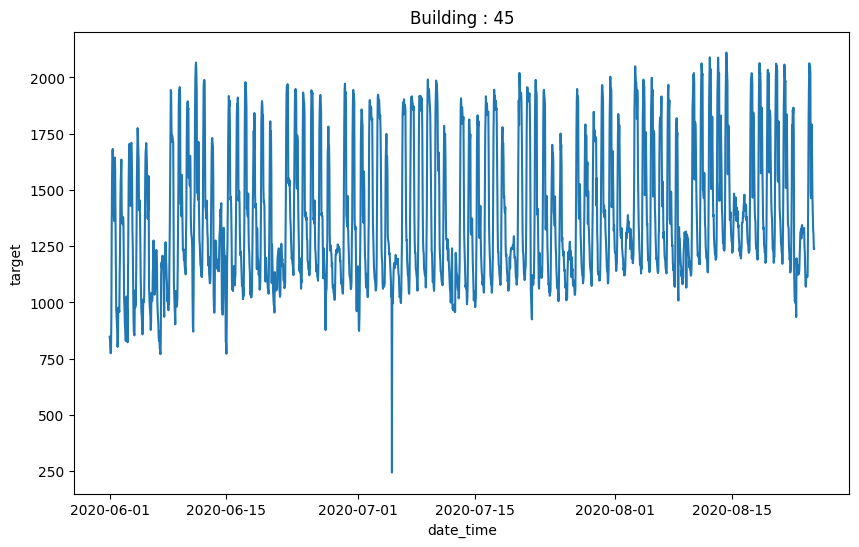

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


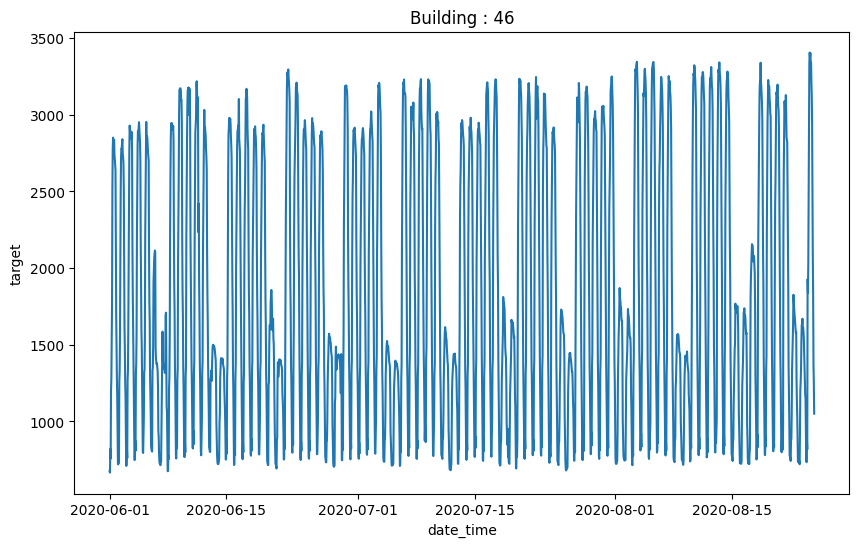

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


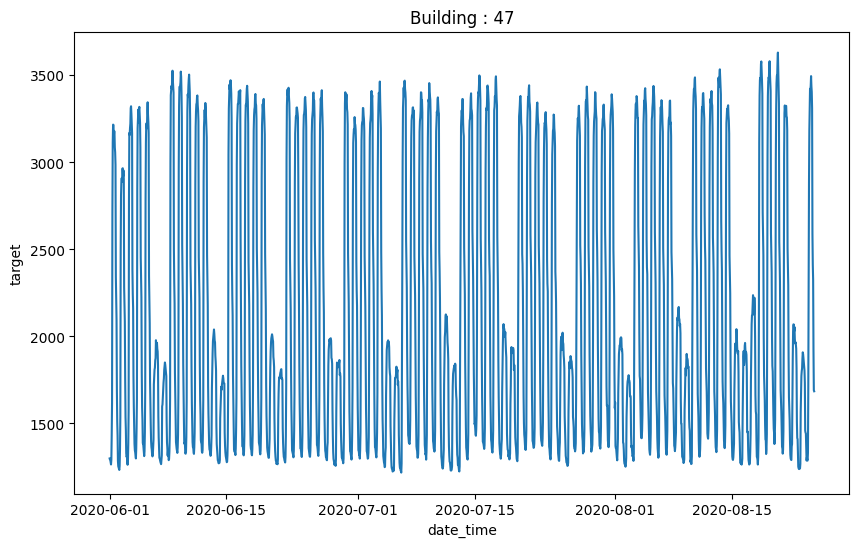

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


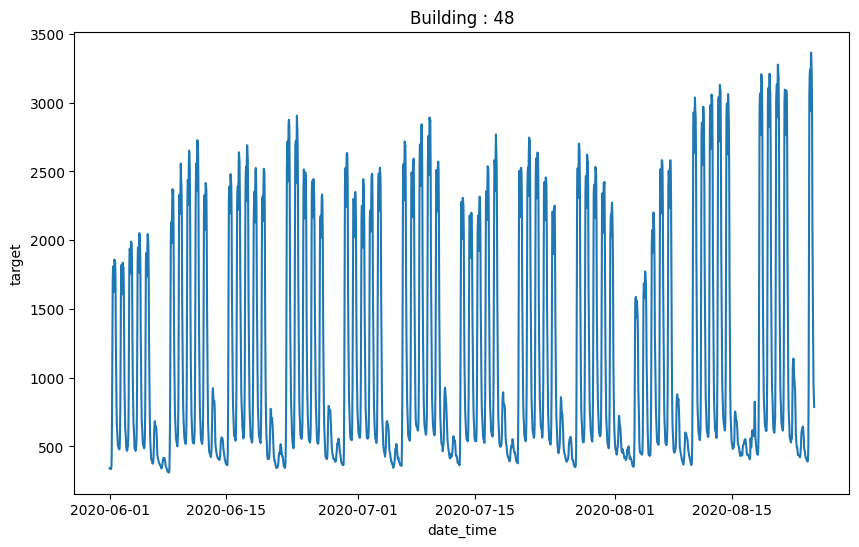

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


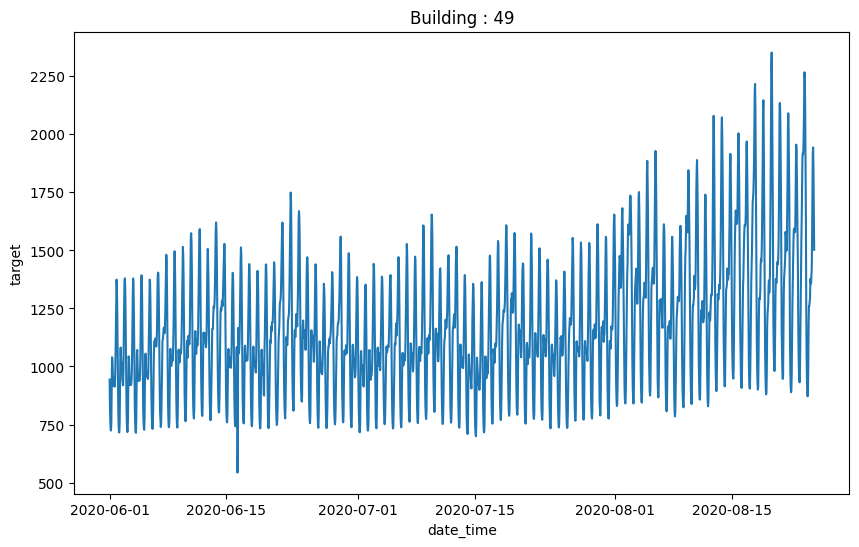

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


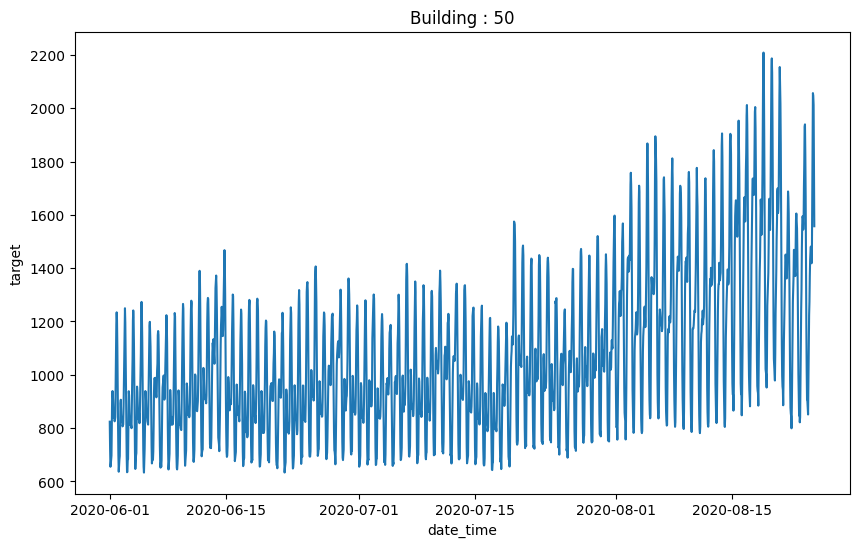

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


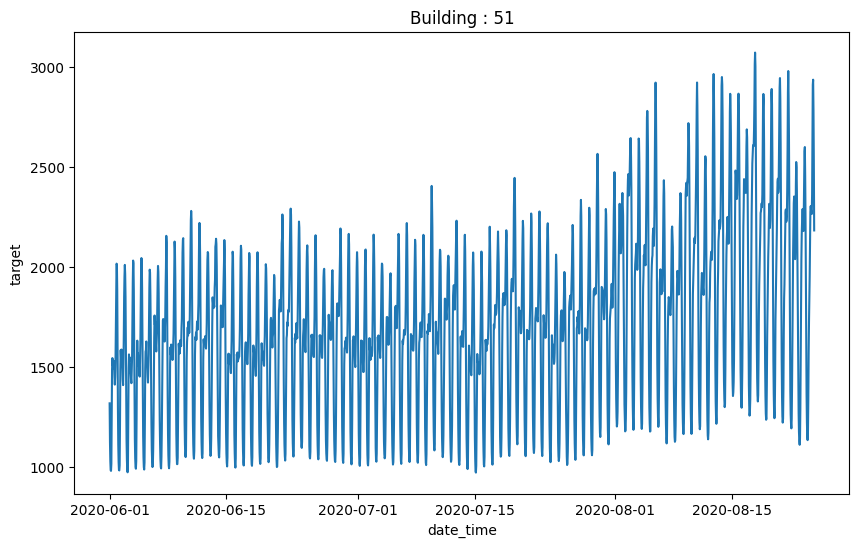

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


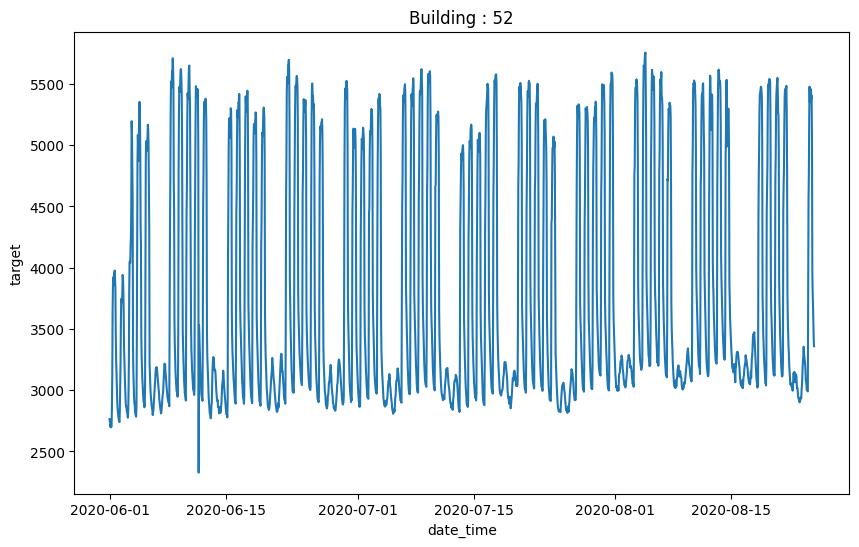

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


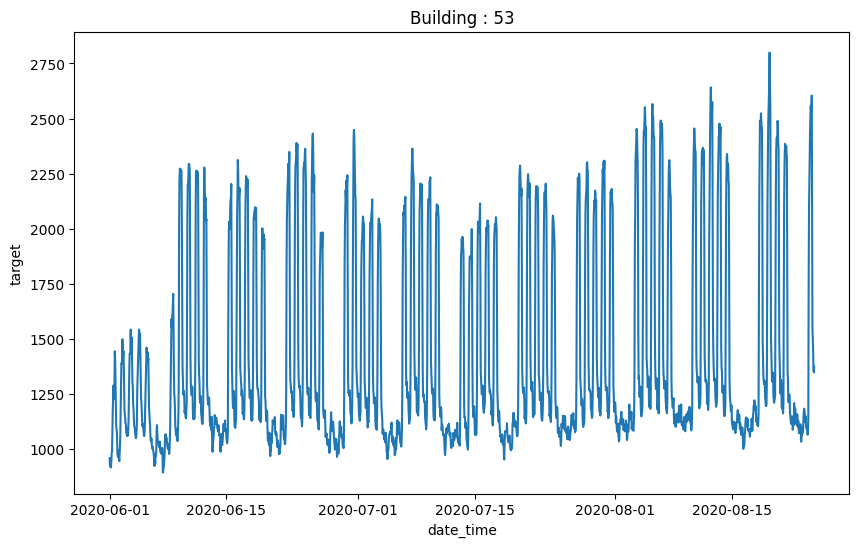

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


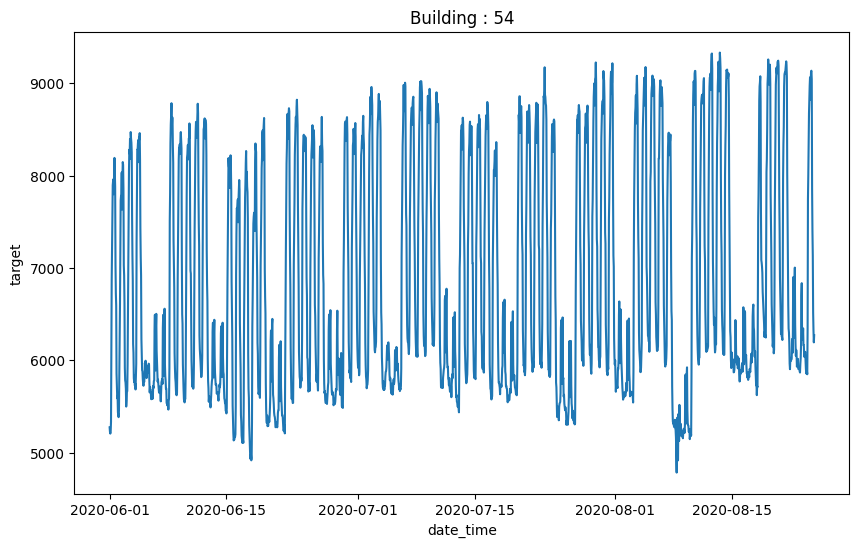

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


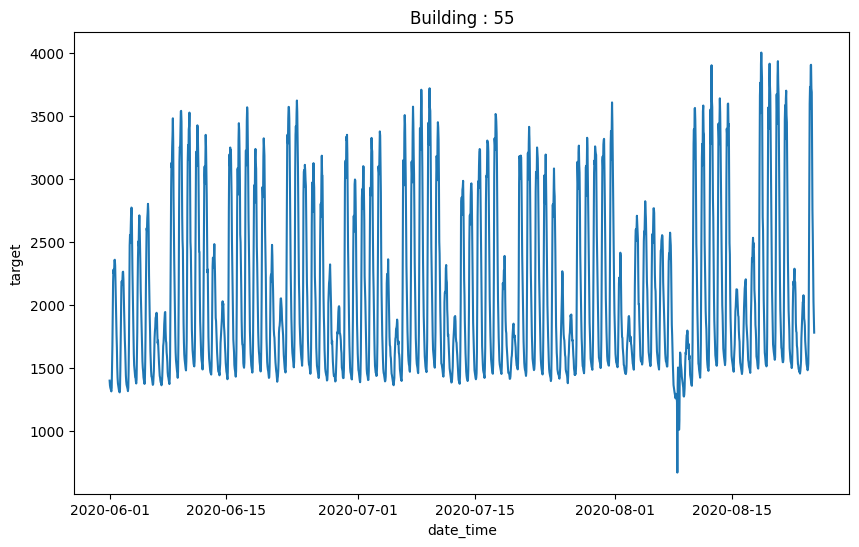

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


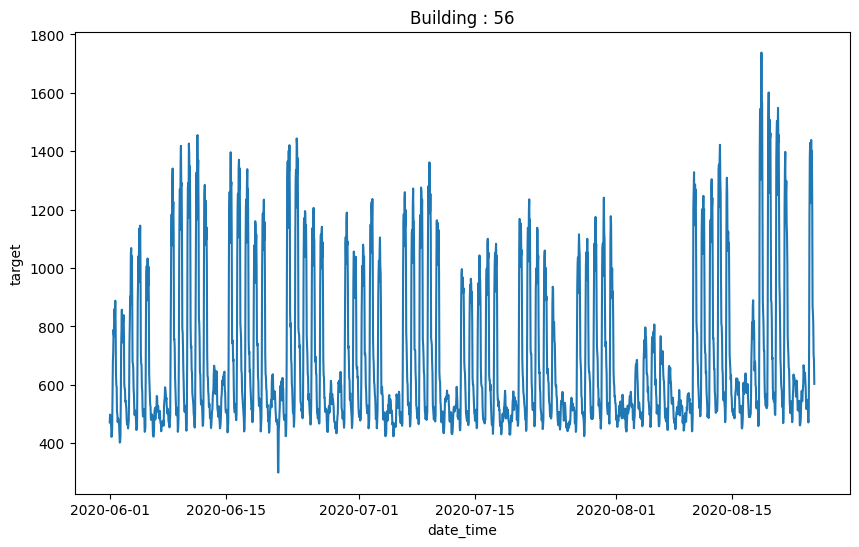

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


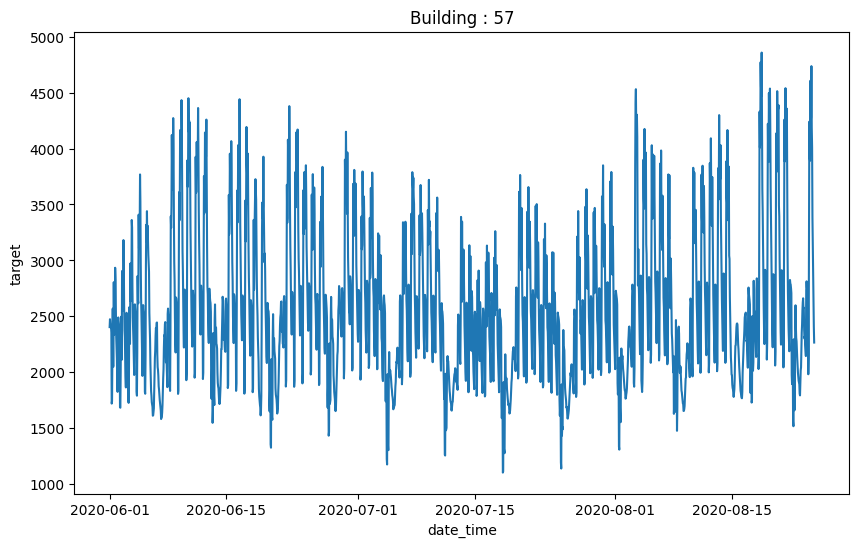

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


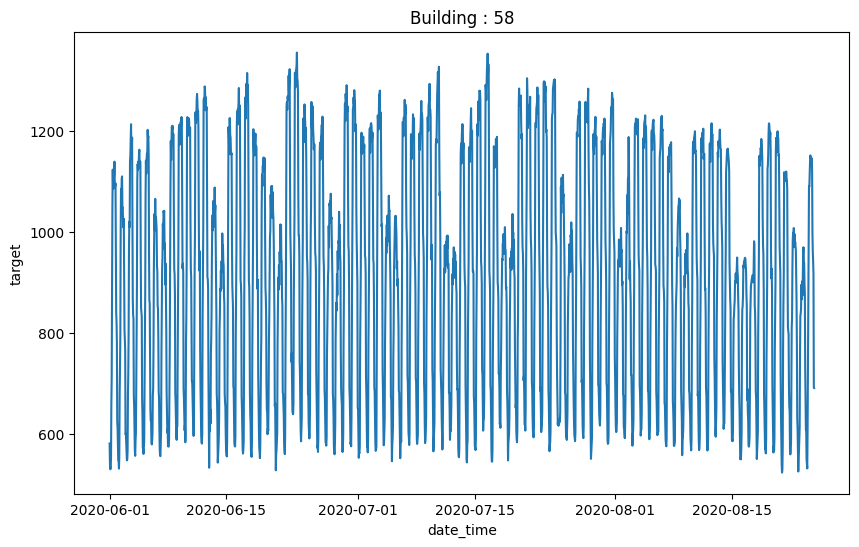

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


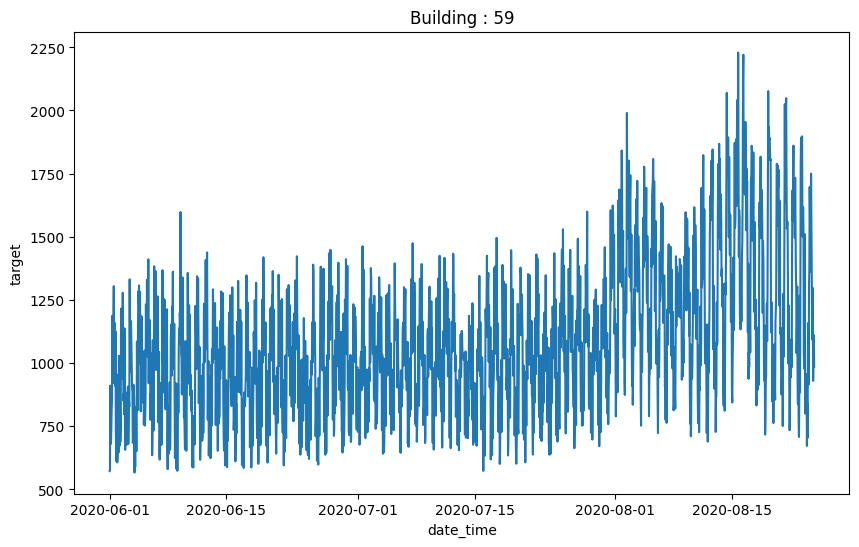

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2075535618.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)


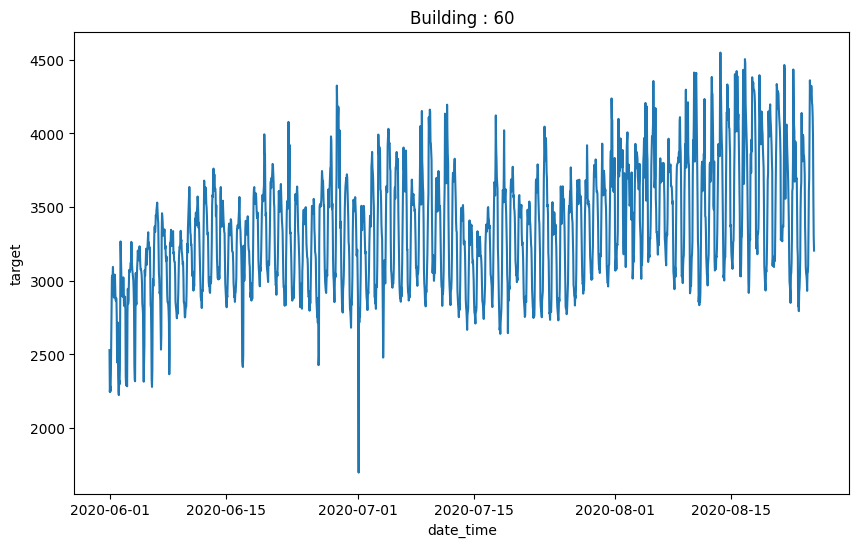

In [41]:
# 시계열 찍어보기
for n in range(1, 61) :
    plt.figure(figsize=(10,6))
    plt.title(f"Building : {n}")
    sns.lineplot(data=train.loc[train.num == n], x = "date_time", y = "target", ci = None)
    # plt.subplots() 
    plt.show()

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2020010653.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data = train, x = "date_time", y = "temperature", ci = None) # ci = confidence interval
/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/2020010653.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data = train, x = "date_time", y = "humidity", ci = None)


<AxesSubplot: xlabel='date_time', ylabel='temperature'>

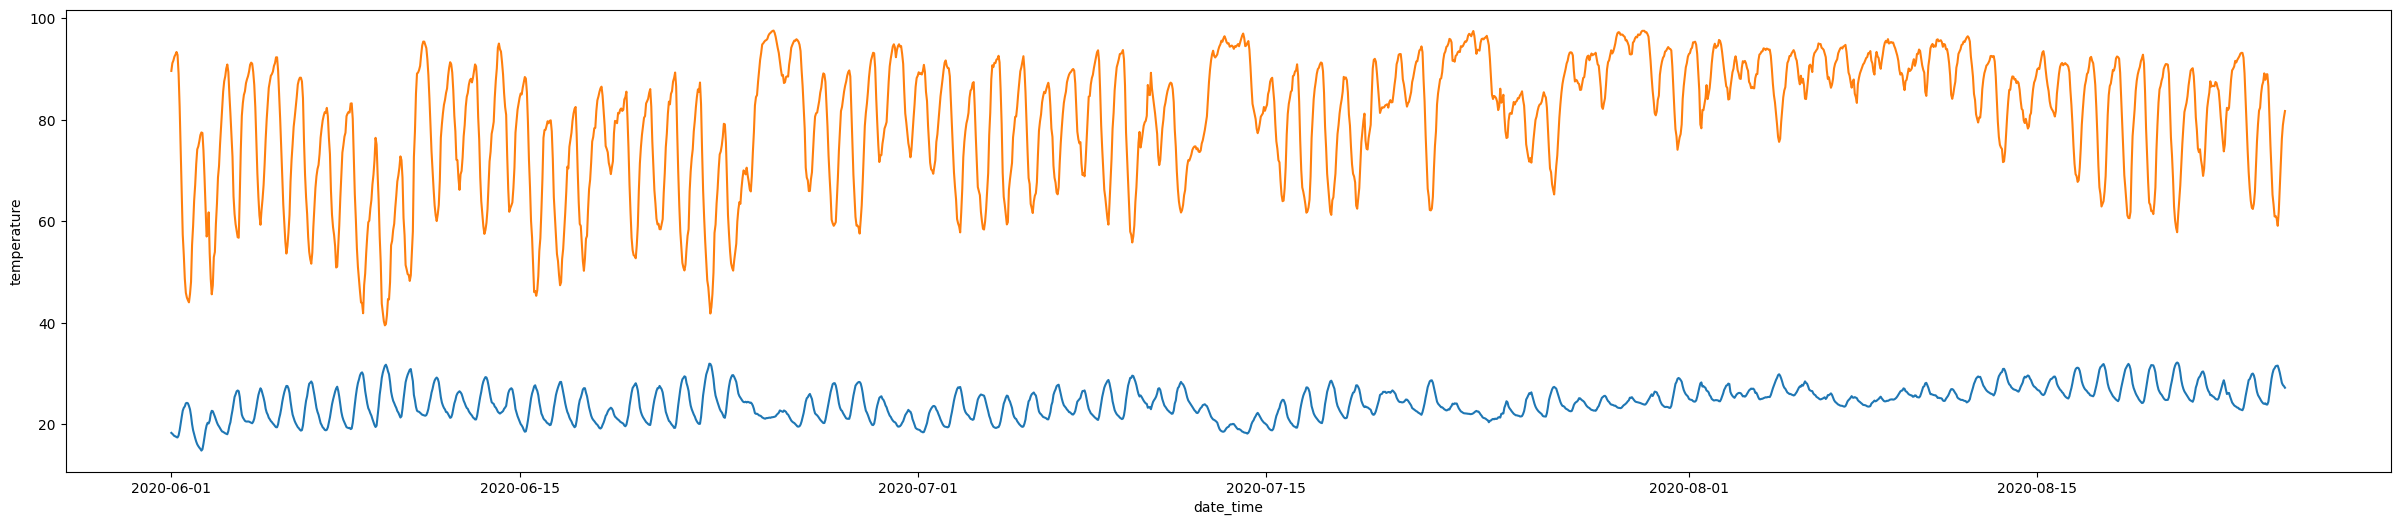

In [42]:
# test data 결측치 처리

# 1. 기상 정보들의 결측치 처리
# 특징 : 시간에 따라 계속 변하는 값이기 때문에 연속성이 높다. 따라서 평균 값으로 nan값을 채우면 문제가 생길 것이란 것을 알아채야 한다.
# 결론 : 선형보관법(linear interpolation)을 적용한다!!!
plt.figure(figsize = (30, 6))
sns.lineplot(data = train, x = "date_time", y = "temperature", ci = None) # ci = confidence interval 
sns.lineplot(data = train, x = "date_time", y = "humidity", ci = None)

In [43]:
# 선형보관법(linear interpolation)을 적용해 결측치 해결
test.temperature = test.temperature.interpolate(method = "linear")
test.humidity = test.humidity.interpolate(method = "linear")
test.windspeed = test.windspeed.interpolate(method = "linear")
test.insolation = test.insolation.interpolate(method = "linear")
test.precipitation = test.precipitation.interpolate(method = "linear")
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   num            10080 non-null  int64         
 1   date_time      10080 non-null  datetime64[ns]
 2   temperature    10080 non-null  float64       
 3   windspeed      10080 non-null  float64       
 4   humidity       10080 non-null  float64       
 5   precipitation  10080 non-null  float64       
 6   insolation     10080 non-null  float64       
 7   elec_cool      2296 non-null   float64       
 8   solar          1624 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 708.9 KB


In [44]:
# 2. 건물 정보의 결측치 처리
# train에 있는 건물별 각 시간의 건물 정보를 그대로 쓸 수 있지 않을까?

## to-do 
# 1) train에 있는 각 건물별로 elec_cool_flag와 solar가 같은지 체크
# 결과 : 체크 성공 
train.num.value_counts()
check = train.groupby("num").sum()
check.elec_cool / train.num.value_counts()
check.solar / train.num.value_counts()

# 2) 같다면, test data에 같은 건물 번호를 가지는 데이터에 연결
building_info= train[["num", "elec_cool", "solar"]].drop_duplicates()
# pd.merge : 특정 값(열)을 기준으로 데이터프레임을 병합
test = pd.merge(test.drop(columns = ["elec_cool", "solar"]), building_info, on="num")
test

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_24537/3830515649.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  check = train.groupby("num").sum()


num           date_time  temperature  windspeed   humidity  \
0        1 2020-08-25 00:00:00    27.800000   1.500000  74.000000   
1        1 2020-08-25 01:00:00    27.633333   1.366667  75.333333   
2        1 2020-08-25 02:00:00    27.466667   1.233333  76.666667   
3        1 2020-08-25 03:00:00    27.300000   1.100000  78.000000   
4        1 2020-08-25 04:00:00    26.900000   1.166667  79.666667   
...    ...                 ...          ...        ...        ...   
10075   60 2020-08-31 19:00:00    28.633333   3.566667  66.000000   
10076   60 2020-08-31 20:00:00    28.266667   3.833333  67.000000   
10077   60 2020-08-31 21:00:00    27.900000   4.100000  68.000000   
10078   60 2020-08-31 22:00:00    27.900000   4.100000  68.000000   
10079   60 2020-08-31 23:00:00    27.900000   4.100000  68.000000   

       precipitation  insolation  elec_cool  solar  
0                0.0    0.000000        0.0    0.0  
1                0.0    0.000000        0.0    0.0  
2                0.0    0.000000        0.0    0.0  
3                0.0    0.000000        0.0    0.0  
4                0.0    0.000000        0.0    0.0  
...              ...         ...        ...    ...  
10075            0.0    0.533333        1.0    1.0  
10076            0.0    0.266667        1.0    1.0  
10077            0.0    0.000000        1.0    1.0  
10078            0.0    0.000000        1.0    1.0  
10079            0.0    0.000000        1.0    1.0  

[10080 rows x 9 columns]

In [45]:
# Time feature (derived feature) -> 회귀분석 안하는 대신 시간정보를 가공해 새로운 feature를 만들어주자. 
# train.date_time.dt.date
# train.date_time.dt.day
# train.date_time.dt.month
# train.date_time.dt.year
# train.date_time.dt.dayofweek # 요일정보 : 월화수목금토일 -> 0123456

# 함수로 만들면 커스터마이징 가능하다.
# def is_weekend(x) : 
#   if x.dt.datofweek in [5,6] :
#     return 1
#   else: 
#     return 0

def convert_hour(x) : 
    return x.hour

train['dow'] = train.date_time.dt.dayofweek
train['hour'] = train.date_time.apply(convert_hour)
train

num           date_time    target  temperature  windspeed  humidity  \
0         1 2020-06-01 00:00:00  8179.056         17.6        2.5      92.0   
1         1 2020-06-01 01:00:00  8135.640         17.7        2.9      91.0   
2         1 2020-06-01 02:00:00  8107.128         17.5        3.2      91.0   
3         1 2020-06-01 03:00:00  8048.808         17.1        3.2      91.0   
4         1 2020-06-01 04:00:00  8043.624         17.0        3.3      92.0   
...     ...                 ...       ...          ...        ...       ...   
122395   60 2020-08-24 19:00:00  4114.368         27.8        2.3      68.0   
122396   60 2020-08-24 20:00:00  3975.696         27.3        1.2      71.0   
122397   60 2020-08-24 21:00:00  3572.208         27.3        1.8      71.0   
122398   60 2020-08-24 22:00:00  3299.184         27.1        1.8      74.0   
122399   60 2020-08-24 23:00:00  3204.576         27.1        2.6      75.0   

        precipitation  insolation  elec_cool  solar  dow  hour  
0                 0.8         0.0        0.0    0.0    0     0  
1                 0.3         0.0        0.0    0.0    0     1  
2                 0.0         0.0        0.0    0.0    0     2  
3                 0.0         0.0        0.0    0.0    0     3  
4                 0.0         0.0        0.0    0.0    0     4  
...               ...         ...        ...    ...  ...   ...  
122395            0.0         0.7        1.0    1.0    0    19  
122396            0.0         0.0        1.0    1.0    0    20  
122397            0.0         0.0        1.0    1.0    0    21  
122398            0.0         0.0        1.0    1.0    0    22  
122399            0.0         0.0        1.0    1.0    0    23  

[122400 rows x 12 columns]

### 3. Data Preparation

In [46]:
# 예측에 사용하지 않을 columns
train = train.drop(columns = ["num", "date_time"])

In [47]:
# 트테트테
# validation dataset과 test dataset의 크기를 맞추면 좋다.
from sklearn.model_selection import train_test_split

X = train.drop(columns = "target") # feature vector
y = train.target # target value

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(110160, 9) (12240, 9) (110160,) (12240,)


### 4. Training 

In [52]:
#!pip install lightgbm

In [51]:
from sklearn.linear_model import LinearRegression
from lightgbm.sklearn import LGBMRegressor
from sklearn.preprocessing import StandardScaler
# standard scaler : x = (x-mean)/std

scaler = StandardScaler()
scaler.fit(X_train) # X_train을 스케일해준다 -> X_train의 column별 avg, std를 구합니다 -> X_scaled = (X - mean(X))/std(X)
X_train_scaled = scaler.transform(X_train) # 변환
X_val_scaled = scaler.transform(X_val) # 변환

reg = LinearRegression()
reg2 = LGBMRegressor()

reg.fit(X_train_scaled, y_train)
reg2.fit(X_train, y_train)

OSError: dlopen(/usr/local/Caskroom/miniforge/base/envs/fcamp/lib/python3.8/site-packages/lightgbm/lib_lightgbm.so, 6): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: /usr/local/Caskroom/miniforge/base/envs/fcamp/lib/python3.8/site-packages/lightgbm/lib_lightgbm.so
  Reason: image not found

### 5. Evaluation
- SMAPE(Symmetric mean absolute percentage error) : 작을 수록 성과가 좋음을 의미

In [ ]:
def smape(true, pred):
    true = np.array(true)  # np.array로 바꿔야 에러 없음
    pred = np.array(pred)
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred)))  # *2 , *100은 상수이므로 생략

pred_train = reg.predict(X_train_scaled)
pred_val = reg.predict(X_val_scaled)

pred_train2 =  reg2.predict(X_train)
pred_val2 = reg2.predict(X_val)

print("--- Linear Regression ---")
print("Train SMAPE : %.4f" % smape(y_train, pred_train))
print("val SMAPE : %.4f" %smape(y_val, pred_val))

print("\n--- LightGBM Regressor ---")
print("Train SMAPE : %.4f" % smape(y_train, pred_train2))
print("val SMAPE : %.4f" %smape(y_val, pred_val2))

### 6. Hyper Parameter Tuning
- GridsearchCV : 주어진 하이퍼파라미터 조합을 모두 테스트하는 방법

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

"""
파라미터 설명 공식 다큐먼츠
https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
"""

""" 
LGBMRegressor() 파라미터 종류들
num_leaves: int = 31, max_depth: int = -1, learning_rate: float = 0.1, n_estimators: int = 100, 
subsample_for_bin: int = 200000, objective: Any | None = None, class_weight: Any | None = None, 
min_split_gain: float = 0, min_child_weight: float = 0.001, min_child_samples: int = 20, subsample: float = 1, 
subsample_freq: int = 0, colsample_bytree: float = 1, reg_alpha: float = 0, reg_lambda: float = 0, random_state: Any | None = None, 
n_jobs: int = -1, silent: bool = True, importance_type: str = 'split', **kwargs: Any) -> None
"""

"""
max_depth: int = -1
num_leaves: int = 31
learning_rate: float = 0.1
n_estimators: int = 100
min_child_samples: int = 20
"""

param_grid = {
    "n_estimators" : [100, 200],
    "num_leaves" : [31, 127],
    "learning_rate" : [0.1, 0.01],
    "min_child_samples" : [10, 20],
    "random_state" : [42]
} # 2x2x2x2x1 = 16가지 하이퍼파라미터 조합을 테스트한다. 

smape_func = make_scorer(smape)
gcv = GridSearchCV(LGBMRegressor(), param_grid, scoring = smape_func, verbose = 1)
gcv.fit(X_train, y_train)

In [ ]:
best_model = gcv.best_estimator_
best_model

In [ ]:
pred_train2 =  best_model.predict(X_train)
pred_val2 = best_model.predict(X_val)

print("\n--- LightGBM Regressor ---")
print("Train SMAPE : %.4f" % smape(y_train, pred_train2))
print("val SMAPE : %.4f" %smape(y_val, pred_val2))

### 7. Prediction & Submission


In [94]:
## To-do : test 데이터를 train 데이터와 같은 전처리를 적용해서 best_model로 예측한 값을 result라는 변수에 저장해주세요.
test['dow'] = test.date_time.dt.dayofweek
test['hour'] = test.date_time.dt.hour
X_test = test.drop(columns = ["num", "date_time"])
result = best_model.predict(X_test)
result

array([2052.70536572, 2052.70536572, 2052.70536572, ..., 2370.87954826,
       2334.74052853, 2334.74052853])

In [97]:
submission = pd.read_csv(base_path + "sample_submission.csv")
submission["answer"] = result
submission.to_csv("sample_submission.csv", index = False)